In [1]:
# import libraries
import os
import scipy.io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interpn
from scipy.interpolate import interp1d
import pickle 
import xarray as xr
import matplotlib.colors as colors

# for mapping
import cartopy.crs as ccrs
# https://cosima-recipes.readthedocs.io/en/latest/tutorials/Making_Maps_with_Cartopy.html
import cartopy.feature as cft
# BIG issue with cartopy: see here https://github.com/SciTools/cartopy/issues/1325 at @jypeter
# I had to download a bunch of stuff myself and put it in ~/.local/share/cartopy/shapefile/.../...
# https://stackoverflow.com/questions/30030328/correct-placement-of-colorbar-relative-to-geo-axes-cartopy
# https://scitools.org.uk/cartopy/docs/v0.15/examples/axes_grid_basic.html
land_110m = cft.NaturalEarthFeature('physical', 'land', '110m', edgecolor='black', facecolor='gray', linewidth=0.5) # continents

# Extract and clean Henson's data

In [2]:
# Carbon export data
henson_data = scipy.io.loadmat('expHensonmod.mat')
latH = np.concatenate(henson_data['lat'])
lonH = np.concatenate(henson_data['lon'])
FexpH_raw = henson_data['exportC'] # units in gC/m2/year

# We need to add 8 latitudes points so that latH goes from -89.5 to 89.5
# otherwise the interpolation with Tim's grid will be translated downwards
add_latH = np.array([-82.5,-83.5,-84.5,-85.5,-86.5,-87.5,-88.5,-89.5])
latH = np.concatenate((latH, add_latH), axis = 0)

# Therefore, we need to add 8 blank lines in the Arctic region
add_blank = np.zeros((8,360))
add_blank[:] = np.NaN

# Cleaned carbon export (before interpolation on Tim's grid)
FexpH_raw = np.concatenate((FexpH_raw, add_blank))

# Primary Production of Henson et al., (2012)
ppHenson = scipy.io.loadmat('Figure4mats.mat')
ppH_raw = ppHenson['PP'] # units in gC m-2 year-1
ppH_raw = np.concatenate((ppH_raw, add_blank)) 
ppH_raw = np.concatenate((ppH_raw[:,100:], ppH_raw[:,:100]), axis = 1) # shift longitude 100° westwards

# export
epH_raw = ppHenson['EP'] # check units -> OK gC m-2 year-1
epH_raw = np.concatenate((epH_raw, add_blank)) 
epH_raw = np.concatenate((epH_raw[:,100:], epH_raw[:,:100]), axis = 1) # shift longitude 100° westwards

# Attenuation factor *b* from Martin et al., (1987); Guidi et al., (2015) and Henson et al., (2012).

In [3]:
# load data
b_data = open("./b_data.pkl", "rb")
b_data = pickle.load(b_data)
b_martin = b_data['b_martin'] # b = 0.86
b_guidi = b_data['b_guidi'] # geographyically variable b
b_henson = b_data['b_henson'] # regionalized b

# Extract and clean Tim's data

In [4]:
tim_data = scipy.io.loadmat('F100.mat') 
f100 = tim_data['F100'] # # f100 (dimensionless) is the percentage of sequestered carbon
latT = np.concatenate(tim_data['lat'])
lonT = np.concatenate(tim_data['lon'])
depthT = np.concatenate(tim_data['depth']) # units = m

# Tim's longitude are eastward so from 0 to 360. I want -180 to 180 to fit my grid hence we do a bit translation.
f100 = np.concatenate((f100[:,90:,:], f100[:,:90,:]), axis = 1)
lonT = np.linspace(-179, 179, 180)

# replace 1 by 0 in Tim's first layer because it should not be 100% of sequestration at the surface (in his case, 4 meters).
f100[:,:,0] = np.where(f100[:,:,0] == 1 , 0, f100[:,:,0])

# Extract and clean SIMPLE TRIM's data

In [5]:
# open netcdf
#file = 'SIMPLE_TRIM_output.nc' # there was an error in that file
file = 'SIMPLE_TRIM_output_CORRECTED.nc'
with xr.open_dataset(file, decode_times=False) as ds:
    ds
    
# maskST = np.array(ds.mask[0,:,:]) # we don't use it
# maskST = np.transpose(maskST)
# maskST = np.concatenate((maskST[:,90:], maskST[:,:90]), axis = 1)
latST = np.array(ds.LAT[0,0,:])
lonST = np.array(ds.LON[0,:,0])
# it has been checked but lonST = lonT et latT = latST -> no need to interpolate, it's the same resolution
# lonST -180 == lonT
# latST == latT
depthST = np.array(ds.DEPTH[:,0,0])

# Euphotic depth
Zeu = ds.Zeu[0,:,:]
Zeu = np.transpose(np.array(Zeu))
Zeu = np.concatenate((Zeu[:,90:], Zeu[:,:90]), axis = 1) # Centered on Europe

# Export flux at 100m 
FexpT = ds.FPOC100m
FexpT = np.transpose(FexpT, [0,2,1]) * 12/1000 # transpose + convert mmolC/m2/year to gC/m2/year
FexpT = np.concatenate((FexpT[:,:,90:], FexpT[:,:,:90]), axis = 2) # center it on Europe

# Export flux at the euphotic depth
FexpZeu = ds.FPOCex 
FexpZeu = np.transpose(FexpZeu, [0,2,1]) * 12/1000
FexpZeu = np.concatenate((FexpZeu[:,:,90:], FexpZeu[:,:,:90]), axis = 2)

# Pixel area
pixelArea = np.transpose(np.array(ds.Area)) #m2

def transpose_translate_data(ds_data):
    """
    This function does an average of the input data then transpose and translate it.
    However, it does not work for all data in SIMPLE-TRIM (it needs 4 dimensions and needs to be checked before so be careful with that) 
    """
    data = np.transpose(ds_data, [0,3,2,1]) 
    data = np.concatenate((data[:,:,90:,:], data[:,:,:90,:]), axis = 2) 
    data = data * 12/1000 # conversion from mmolC to gC
    return(data)

# Dissolved organic carbon (DOC)
DOCl = transpose_translate_data(ds.DOCl)
DOCsl = transpose_translate_data(ds.DOCsl)
DOCsr = transpose_translate_data(ds.DOCsr)
DOCr = transpose_translate_data(ds.DOCr)

# DOC remineralization rates
kl = np.array(ds.k_L)
ksl = np.array(ds.k_SL)
ksr = np.array(ds.k_SR)
kr = np.array(ds.k_R)

# Particulate organic carbon (POC) fluxes
POCflux = transpose_translate_data(ds.POCflux)

# slow and fast POC
POCslow = transpose_translate_data(ds.POCslow)
POCfast = transpose_translate_data(ds.POCfast)
kslow = np.array(ds.gamma_S)
kfast = np.array(ds.gamma_F)

# doxy obs
o2_obs = np.array(ds.O2obs)
o2_obs = np.transpose(o2_obs, [2,1,0])
o2_obs = np.concatenate((o2_obs[:,90:,:], o2_obs[:,:90,:]), axis = 1) 

# kO2
Ko2 = np.array(ds.Ko2)

# Q10
q10 = np.array(ds.q10)

# T
Tref = 20 # see annexes
temp = np.array(ds.Temp)
temp = np.transpose(temp, [2,1,0])
temp = np.concatenate((temp[:,90:,:], temp[:,:90,:]), axis = 1) 

# Interpolation of f100 on the 24 depths of SIMPLE-TRIM

In [6]:
f100_ST = np.zeros((91,180,24)) # 24 depths in SIMPLE-TRIM

for i, lat in enumerate(latT):
    for j, lon in enumerate(lonT):
        r = int(np.array(np.where(latT == lat))) # r for row
        c = int(np.array(np.where(lonT == lon))) 
        tmp = f100[r,c,:]
        # interpolated f100
        f = interp1d(depthT, tmp)
        yvals = f(depthST)
        #yvals = np.interp(depthST, depthT, tmp) # works as well
        f100_ST[r,c,:] = yvals
        
# Sometimes, the interpolation does not go to the last depth of the profile.
# Hence, for those pixels, we put the last f100_ST to be the last f100
for i, lat in enumerate(latT):
    for j, lon in enumerate(lonT):
        r = int(np.array(np.where(latT == lat))) # r for row
        c = int(np.array(np.where(lonT == lon))) 
        tmp = f100[r,c,:]
        #print(r,c)
        length_poc_flux = np.sum(~np.isnan(POCflux[0,r,c,])) 
        length_f100_ST = np.sum(~np.isnan(f100_ST[r,c,]))
        if (~np.isnan(tmp[0])) & (length_poc_flux != length_f100_ST):
            last_f100 = f100[r,c,~np.isnan(f100[r,c,])][-1]
            f100_ST[r,c,length_poc_flux-1] = last_f100
        
# # visual check 
# r = 40
# c = 40
# tmp = f100[r,c,:]
# # interpolated f100
# f = interp1d(depthT, tmp)
# xnew = depthST
# ynew = f(xnew)   # use interpolation function returned by `interp1d`
# #plt.plot(depthT, tmp, 'o', xnew, ynew, '-')
# plt.plot(depthT, tmp, 'o', xnew, f100_ST[r,c,:], 'x')
# plt.show()

# Computation of the deepest depth before reaching the sediment using Tim's data

In [7]:
# compute max depth before reaching the sediment
zmax = np.zeros(f100[:,:,0].shape)

# NOTE : I did not make the distinction between oceans and inland waters. However, f100 is only defined in 'ocean'
# waters so the problem goes away by itself. We should then see the 'ocean' points at depth < 100 m in white
# on the maps

for i, lat in enumerate(latT):
    for j, lon in enumerate(lonT):
        r = int(np.array(np.where(latT == lat))) # r for row
        c = int(np.array(np.where(lonT == lon))) 
        tmp = f100[r,c,:]
        if (all(np.isnan(tmp)) == False) & (np.isnan(np.sum(tmp))): # so we are not on a 'land' pixel or on a deep point (with data at 5581 m)
            index = np.argwhere(np.isnan(tmp))[0][0]
            zmax[r,c] = depthT[index-1]
        elif np.isnan(np.sum(tmp)) == False: # we are in the case of the 5581m layer
            zmax[r,c] = np.max(depthT)
        else:
            zmax[r,c] = np.nan

# mask pixels where Zmax < 100m
zmax_with_shallow_pixels = np.copy(zmax)
zmax = np.where(zmax<100, np.nan, zmax) 

# create mask
mask = np.where(zmax > 0.0, 1.0, zmax) # it masks the pixel < 100 m depth and some inland seas 
#mask = np.where(mask != 1.0, 0.0, mask) # was used to check if mask was equal to maskST -> yes

# check if previous step is ok
# np.argwhere(zmax == np.nanmax(zmax))
# np.argwhere(~np.isnan(f100[:,:,47]))

# ok it gives the same output

In [8]:
# I need to compute a matrix of deltaZ actually
deltaZ_matrix = np.zeros(POCflux[0,:,:,:].shape)
for i, lat in enumerate(latT):
    for j, lon in enumerate(lonT):
        r = int(np.array(np.where(latT == lat))) # r for row
        c = int(np.array(np.where(lonT == lon))) # c for column
        tmp = POCflux[0,r,c,:] # index 0 for version but it does not matter here
        index_bottom = np.argmin(POCflux[0,r,c,:]) # give the index of the layer below the last layer
        deepest_depth = depthST[index_bottom-1]
        mask_pixel = mask[r,c]
        if np.isnan(mask_pixel): # land pixel ou < 100 m pixel
            deltaZ_matrix[r,c,:] = np.nan
        else:
            for k, depth in enumerate(depthST[:index_bottom]):
                if depth == depthST[0]: # case at the surface
                    deltaZ_matrix[r,c,k] = (depthST[k]+depthST[k+1])/2
                elif depth == deepest_depth: # case at the bottom
                    deltaZ_matrix[r,c,k] = deepest_depth - ((depthST[k-1]+deepest_depth)/2)
                    deltaZ_matrix[r,c,k+1:] = np.nan
                else:
                    deltaZ_matrix[r,c,k] = ((depthST[k]+depthST[k+1])/2) - ((depthST[k-1]+depthST[k])/2)

# Interpolate Henson's data on Tim's grid (coarser grid)

In [9]:
RlatH = latH[::-1] # reverse latH for ascending order needed by scipy

points = (RlatH, lonH)
values = FexpH_raw

RlatT = latT[::-1] 
RlonT = lonT[::-1]

FexpH = []
for i, lat in enumerate(RlatT):
    for j, lon in enumerate(lonT):
        point = np.array([lat,lon])
        try:
            tmp = float(interpn(points, values, point, method = 'nearest'))
            FexpH.append(tmp)
        except:
            tmp = np.nan
            FexpH.append(tmp)
            
FexpH = np.array(FexpH).reshape((91, 180)) # shape of f100 (Tim's data)      
# print(np.nanmax(FexpH))
# print(np.nanmean(FexpH))

# same for the primary production
# interpolate PP of Henson on Tim's grid
values = ppH_raw
values2 = epH_raw

ppH = []
epH = []
for i, lat in enumerate(RlatT):
    for j, lon in enumerate(lonT):
        point = np.array([lat,lon])
        try:
            tmp = float(interpn(points, values, point, method = 'nearest'))
            ppH.append(tmp)
            tmp2 = float(interpn(points, values2, point, method = 'nearest'))
            epH.append(tmp2)
        except:
            tmp = np.nan
            ppH.append(tmp)
            tmp2 = np.nan
            epH.append(tmp2)
            
ppH = np.array(ppH).reshape((91, 180)) # shape of f100 (Tim's data)      
epH = np.array(epH).reshape((91, 180))

# Depth of export for Henson (100m)
ZexpH = np.zeros(ppH.shape)
ZexpH.fill(100) # Zexp for Henson is constant and fixed at 100m

# Generic functions to map carbon-related fluxes in the global ocean 

In [10]:
def plot_map_simple(tuple_fig_size, lon, lat, variable, vmin, vmax, title, colorbar_label, savefig, savefig_title, mask = 1, cmap = "viridis"):
    
    fig, ax = plt.subplots(1,1,figsize=tuple_fig_size,subplot_kw={'projection': ccrs.Robinson()})
    ax.add_feature(land_110m)
    ax.coastlines(resolution='110m', color='black', linestyle='-', alpha=1, linewidth = 2)
    p = ax.pcolormesh(lon, lat, variable*mask, shading = 'auto', vmin = vmin, vmax = vmax, transform=ccrs.PlateCarree(), cmap = cmap)
    ax.set_title(title)
    cbar = plt.colorbar(p)
    cbar.set_label(colorbar_label)
    if savefig:
        plt.savefig('./mapsV2/'+savefig_title)
        plt.show()
    else:
        plt.show()

In [11]:
# for a linear colorbar
def plot_map(tuple_fig_size, lon, lat, variable, vmin, vmax, title, colorbar_label, savefig, savefig_title, mask = 1, cmap = "viridis", folder = './mapsV2/', plt_show = True, use_log_scale = False, use_colorbar = True):
    
    fig, ax = plt.subplots(1,1,figsize=tuple_fig_size,subplot_kw={'projection': ccrs.Robinson()})
    ax.add_feature(land_110m)
    ax.coastlines(resolution='110m', color='black', linestyle='-', alpha=1, linewidth = 2)
    ax.set_title(title, size = 40, y = -0.12)
    if use_log_scale:
        p = ax.pcolormesh(lon, lat, variable*mask, shading = 'auto', vmin = vmin, vmax = vmax, transform=ccrs.PlateCarree(), cmap = cmap, norm=colors.LogNorm())
    else:
        p = ax.pcolormesh(lon, lat, variable*mask, shading = 'auto', vmin = vmin, vmax = vmax, transform=ccrs.PlateCarree(), cmap = cmap)
    if use_colorbar:
        cbar = plt.colorbar(p, orientation='horizontal', aspect = 100, pad = 0.05)
        cbar.set_label(colorbar_label, fontsize = 30, labelpad = -10)
        cbar.set_ticks([1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2])
        cbar.set_ticklabels([0.001, 0.01, 0.1, 1, 10, 100])
        cbar.ax.tick_params(labelsize=30)
    if savefig:
        plt.savefig(folder+savefig_title, bbox_inches='tight')
        if plt_show:
            plt.show()
        else:
            plt.close()
    elif plt_show:
        plt.show()
    else:
        plt.close()

# Check ppH with and without the <100m pixel mask

In [12]:
def compute_flux_total(FseqX, pixel_areas):
    """
    Input : a 2D array with fluxes (can be exported, sequestered, remineralized carbon flux) 
    Output: total amount of exported, sequestered, remineralized carbon flux in GtC/year
    """
    res = np.nansum(np.nansum(FseqX * pixel_areas[:,:]*1e-15, axis = 1)) # in GtC year-1 
    return(res)

print(compute_flux_total(ppH, pixelArea)) 
print(compute_flux_total(ppH*mask, pixelArea)) 
ratioExpPP = epH/ppH
#plot_map((20,8), lonT, latT, ratioExpPP, 0, None, '', '', False, '', mask, cmap = "jet")
print(np.nanmean(ratioExpPP))

87.33501488130551
64.4200562104209
0.07670179318198936


# Figure 3

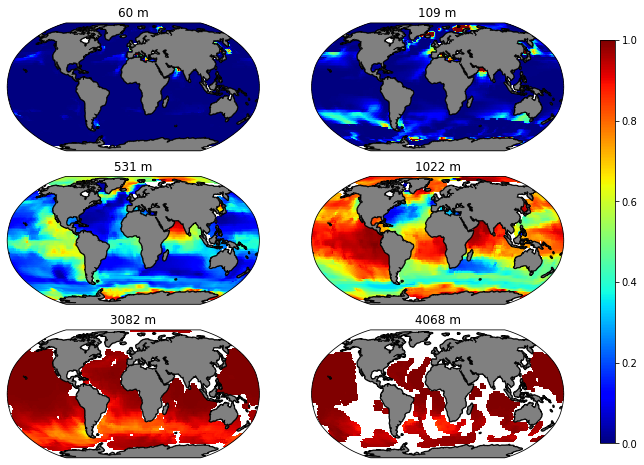

In [13]:
# Big fig
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2,figsize=(10,8),subplot_kw={'projection': ccrs.Robinson()})

pal = 'jet'
#pal = 'RdBu'
#pal = 'gist_rainbow'
#pal = 'cubehelix'

deep_pixel_mask = mask[:,:,np.newaxis]

# fig1
ax1.coastlines(resolution='110m', color='black', linestyle='-', alpha=1, linewidth = 2)
p1 = ax1.pcolormesh(lonT, latT, (f100[:,:,5]*deep_pixel_mask[:,:,0]), vmin = 0, vmax = .3, shading = 'auto', transform=ccrs.PlateCarree(), cmap = pal) # /!\ vmax is saturated at 60 m
d = int(np.floor(depthT[5]))
ax1.add_feature(land_110m)
ax1.set_title(str(d)+ ' m') 

# fig2
ax2.coastlines(resolution='110m', color='black', linestyle='-', alpha=1, linewidth = 2)
p2 = ax2.pcolormesh(lonT, latT, (f100[:,:,8]*deep_pixel_mask[:,:,0]), vmin = 0, vmax = .3, shading = 'auto', transform=ccrs.PlateCarree(), cmap = pal) # /!\ vmax is saturated at 109 m
d = int(np.floor(depthT[8]))
ax2.add_feature(land_110m)
ax2.set_title(str(d)+ ' m') 

# fig3
ax3.coastlines(resolution='110m', color='black', linestyle='-', alpha=1, linewidth = 2)
p3 = ax3.pcolormesh(lonT, latT, (f100[:,:,19]*deep_pixel_mask[:,:,0]), vmin = 0, vmax = 1, shading = 'auto', transform=ccrs.PlateCarree(), cmap = pal)
d = int(np.ceil(depthT[19]))
ax3.add_feature(land_110m)
ax3.set_title(str(d)+ ' m') 

# fig4
ax4.coastlines(resolution='110m', color='black', linestyle='-', alpha=1, linewidth = 2)
p4 = ax4.pcolormesh(lonT, latT, (f100[:,:,25]*deep_pixel_mask[:,:,0]), vmin = 0, vmax = 1, shading = 'auto', transform=ccrs.PlateCarree(), cmap = pal)
d = int(np.ceil(depthT[25]))
ax4.add_feature(land_110m)
ax4.set_title(str(d)+ ' m')

# fig5
ax5.coastlines(resolution='110m', color='black', linestyle='-', alpha=1, linewidth = 2)
p5 = ax5.pcolormesh(lonT, latT, (f100[:,:,38]*deep_pixel_mask[:,:,0]), vmin = 0, vmax = 1, shading = 'auto', transform=ccrs.PlateCarree(), cmap = pal)
d = int(np.floor(depthT[38]))
ax5.add_feature(land_110m)
ax5.set_title(str(d)+ ' m') 

# fig6
ax6.coastlines(resolution='110m', color='black', linestyle='-', alpha=1, linewidth = 2)
p6 = ax6.pcolormesh(lonT, latT, (f100[:,:,42]*deep_pixel_mask[:,:,0]), vmin = 0, vmax = 1, shading = 'auto', transform=ccrs.PlateCarree(), cmap = pal)
d = int(np.floor(depthT[42]))
ax6.add_feature(land_110m)
ax6.set_title(str(d)+ ' m') 

cbar_ax = fig.add_axes([.95, 0.15, 0.02, 0.7])
col = fig.colorbar(p4, cax=cbar_ax)
#col.set_label('[%]')
plt.savefig('./mapsV2/big_fig_f100'+'.jpg', bbox_inches = "tight", dpi=300)

# Inspection of f100 at 60m

In [14]:
f100_60m = f100[:,:,5]*100*deep_pixel_mask[:,:,0] # units in [%]

# f100(60m) > 0.1%
print(np.argwhere(f100_60m >= 0.0).shape[0] - np.argwhere(f100_60m < 0.1).shape[0])

# f100(60m) > 1%
print(np.argwhere(f100_60m >= 0.0).shape[0] - np.argwhere(f100_60m < 1).shape[0])

# f100(60m) > 10%
print(np.argwhere(f100_60m >= 0.0).shape[0] - np.argwhere(f100_60m < 10).shape[0])

2151
500
75


# Compute sequestration flux at 2000m

In [15]:
# Using Martin's law
def compute_FseqPOC_2000m(b_matrix, Fexp_matrix, Zexp_matrix, POCflux, use_ST = False, latT = latT, lonT = lonT, zmax = zmax, depthST = depthST):    
    
    FseqPOC_2000m = np.zeros(Fexp_matrix.shape)
    
    if use_ST == False:
        for i, lat in enumerate(latT):
            for j, lon in enumerate(lonT):
                r = int(np.array(np.where(latT == lat))) # r for row
                c = int(np.array(np.where(lonT == lon))) # c for column
                zmax_pixel = zmax[r,c] # deepest depth of that pixel before reaching the sediment
                b = b_matrix[r,c] 
                Fexp = Fexp_matrix[r,c]
                Zexp = Zexp_matrix[r,c]
                if zmax_pixel >= 2000:
                    Flux_z = compute_FluxC(2000, b, Fexp, Zexp)
                    FseqPOC_2000m[r,c] = Flux_z
                else:
                    FseqPOC_2000m[r,c] = np.nan
    else:
        # basic linear interp (at this depth, the flux is generally constant so basic linear interp is good
        for i, lat in enumerate(latT):
            for j, lon in enumerate(lonT):
                r = int(np.array(np.where(latT == lat))) # r for row
                c = int(np.array(np.where(lonT == lon))) # c for column
                zmax_pixel = zmax[r,c]
                if zmax_pixel >= 2000: # pixel too shallow for sequestration above 2000m
                    slope = (POCflux[r,c,16] - POCflux[r,c,15])/(depthST[16] - depthST[15])
                    FseqPOC_2000m[r,c] = POCflux[r,c,15] + slope*(2000 - depthST[15])
                
    return(FseqPOC_2000m)

# It is time to check if what we have done so far is OK

In [16]:
def compute_flux_total_mean(flux, pixel_area):
    tmp = np.zeros(flux.shape[0])
    for i in range(flux.shape[0]):
        tmp[i] = compute_flux_total(flux[i,:,:], pixelArea)
    
    return(np.mean(tmp))

In [17]:
print(compute_flux_total_mean(FexpT, pixelArea)) # OK with what Tim found
print(compute_flux_total_mean(FexpZeu, pixelArea)) # OK with what Tim found
print(compute_flux_total(FexpH, pixelArea)) # OK with what Henson found

7.338796829045954
8.787427667716868
4.046082981596219


# Computation of the sequestered flux in Open Water

In [18]:
depthT # depth levels from Tim's data

array([4.93454087e+00, 1.48774788e+01, 2.51158413e+01, 3.59450532e+01,
       4.76605389e+01, 6.05577232e+01, 7.49320307e+01, 9.10788861e+01,
       1.09293714e+02, 1.29871939e+02, 1.53108986e+02, 1.79300279e+02,
       2.08741243e+02, 2.41727303e+02, 2.78553883e+02, 3.19516408e+02,
       3.64910303e+02, 4.15030992e+02, 4.70173900e+02, 5.30634451e+02,
       5.96708071e+02, 6.68690183e+02, 7.46876213e+02, 8.31561585e+02,
       9.23041723e+02, 1.02161205e+03, 1.12756800e+03, 1.24120499e+03,
       1.36281844e+03, 1.49270378e+03, 1.63115644e+03, 1.77847183e+03,
       1.93494539e+03, 2.10087254e+03, 2.27654870e+03, 2.46226930e+03,
       2.65832976e+03, 2.86502551e+03, 3.08265197e+03, 3.31150457e+03,
       3.55187872e+03, 3.80406987e+03, 4.06837342e+03, 4.34508481e+03,
       4.63449945e+03, 4.93691279e+03, 5.25262023e+03, 5.58191720e+03])

In [19]:
def compute_Fseq_water(z1, z2, b, f_100, Fexp, Zexp):
    """
    For sequestration in open waters
    
    INPUTS : z1, z2 : depths above and below depth of interest
             b : Martin's coefficient (but can be a one different from Martin like Guidi's one or Henson's one)
             f_100 : % of captured carbon
             Fexp : flux of exported carbon 
             Zexp : depth of export 
    OUTPUT : Fseq : the flux of sequestered carbon
    """
    
    if (np.isnan(b)) | (np.isnan(f_100)) | (np.isnan(Fexp)):
        Fseq = np.nan
        Fremin = np.nan
    elif z1 == 0: # because raising 0 to a power raises an error
        Fremin = Fexp * (0-((z2/Zexp)**b))
        Fseq = Fremin * f_100
    else:
        Fremin = Fexp * ((z1/Zexp)**b - ((z2/Zexp)**b)) # delta_flux = Fremin(pixel, depth)
        Fseq = Fremin * f_100 # units gC m-2 year-1
    return(Fremin, Fseq)

In [20]:
def compute_sequestration_in_water(zmax_matrix, depthX, b_matrix, f100_matrix, Fexp_matrix, Zexp_matrix, latT = latT, lonT = lonT):
    
    """
    For computing the sequestration flux in open water
    INPUTS : latT, lonT : arrays of discrete latitudes and longitudes
             zmax_matrix : array of maximum depth per pixel before reaching the sediment
             depthX : array of depth layers
             b_matrix : array of b values per pixel
             f100_matrix : array of f100 values per pixel 
             Fexp_matrix : array of export flux per pixel
             Zexp_matrix : array of depth of export per pixel
    OUTPUT : Fseq_water : the sequestered carbon in open water
    """
    
    # compute the sequestration flux in open water
    # The special case of surface and zmax(pixel) is taken into account.
    
    Fseq_water = np.zeros(f100_matrix.shape) # this will be for the 3D Fseq in open water, units in gC m-2 year-1
    Fremin_water = np.zeros(f100_matrix.shape)

    for i, lat in enumerate(latT):
        for j, lon in enumerate(lonT):
            r = int(np.array(np.where(latT == lat))) # r for row
            c = int(np.array(np.where(lonT == lon))) # c for column
            zmax_pixel = zmax_matrix[r,c] # deepest depth of that pixel before reaching the sediment
            # NOTE: depending on the version of zmax (with or without shallow (<100m) pixels, there is no need to apply the mask here) =============> WELL THAT IS NOT TRUE, IF WE USE ALL PIXELS, THEN WE NEED TO ADD THAT THERE IS NO SEQUESTRATION IN THE WATER FOR ZMAX(PIXELS) < 100m
            b = b_matrix[r,c] # for the paper, we'll only use Martin's b. Maybe Lionel's or Henson's for supp. material
            Fexp = Fexp_matrix[r,c]
            Zexp = Zexp_matrix[r,c]
            for k, depth in enumerate(depthX):
                f100_z = f100_matrix[r,c,k]
                if np.isnan(zmax_pixel): # land pixel
                    Fseq_water[r,c,:] = np.nan
                    Fremin_water[r,c,:] = np.nan
                    break
                elif depth == np.min(depthX): # special case at the surface
                    z1 = 0
                    z2 = (depthX[k]+depthX[k+1])/2
                    Fremin_z, Fseq_z = compute_Fseq_water(z1, z2, b, f100_z, Fexp, Zexp) # z for Fseq at that particular depth z
                    Fseq_water[r,c,k] = Fseq_z
                    Fremin_water[r,c,k] = Fremin_z
                elif depth == zmax_pixel: # special case at the deepest depth (before reaching sediments)
                    #z1 = (depthX[k-1]+depthX[k])/2
                    z1 = (depthX[k-1]+zmax_pixel)/2
                    z2 = zmax_pixel
                    Fremin_z, Fseq_z = compute_Fseq_water(z1, z2, b, f100_z, Fexp, Zexp) 
                    Fseq_water[r,c,k] = Fseq_z
                    Fremin_water[r,c,k] = Fremin_z
                    if(zmax_pixel != np.max(depthX)): # we reached the zmax of that pixel so all values below should be nan
                        Fseq_water[r,c,k+1:] = np.nan
                        Fremin_water[r,c,k+1:] = np.nan
                        break # go to next lat/lon point
                else:
                    z1 = (depthX[k-1]+depthX[k])/2
                    z2 = (depthX[k]+depthX[k+1])/2
                    Fremin_z, Fseq_z = compute_Fseq_water(z1, z2, b, f100_z, Fexp, Zexp) 
                    Fseq_water[r,c,k] = Fseq_z
                    Fremin_water[r,c,k] = Fremin_z
    
    return(Fremin_water, Fseq_water)

# Just a reminder to check loops/functions if needed

In [21]:
# land point
r = 0
c = 0

In [22]:
# deepest point (deepest depth reaches 5581 m)
r = 57
c = 59

In [23]:
# normal open water point (not reaching the last depth of 5581 m)
r = 40
c = 40

# Computation of the sequestered flux in the sediment

In [24]:
def compute_Fseq_sed(z, b, Fexp, Zexp):
    """
    For sequestration in the sediment (between the last depth in open water and the sediment)
    
    INPUTS : z : depth before reaching the sediment layer
             b : Martin's coefficient (but can be a one different from Martin like Guidi's one or Henson's one)
             Fexp : flux of exported carbon 
             Zexp : depth of export 
    OUTPUT : Fseq_sed : the sequestered carbon in the sediment
    """
    #Fremin = 0 # -> all is sequestered
    Fseq = Fexp * (z/Zexp)**b * 1 # f100 = 1 here because we assume that 100% of the carbon is sequestered
    return(Fseq)

In [25]:
def compute_sequestration_in_sediment(zmax_matrix, b_matrix, Fexp_matrix, Zexp_matrix, latT = latT, lonT = lonT):
    
    """
    Computation of the sequestration carbon in the sediment. 
    INPUTS : 
    OUTPUT : array of sequestered carbon in the sediment
    """
    # init array
    Fseq_sed = np.zeros(zmax_matrix.shape) # units in gC/m2/year 
    
    # compute flux of sequestered carbon in the sediment
    for i, lat in enumerate(latT):
        for j, lon in enumerate(lonT):
            r = int(np.array(np.where(latT == lat))) # r for row
            c = int(np.array(np.where(lonT == lon))) 
            z = zmax_matrix[r,c]
            b = b_matrix[r,c]
            Fexp = Fexp_matrix[r,c]
            Zexp = Zexp_matrix[r,c]
            Fseq_sed[r,c] = compute_Fseq_sed(z, b, Fexp, Zexp)
    
    return(Fseq_sed)

# Computation of the weighted f100 in the Top layer (ie. From 0 to Zexp) 
### where Zexp could either be at 100 m or at the euphotic depth (Zeu)

In [26]:
f100_Top = np.zeros(f100[:,:,0].shape) # weighted mean of f100 in the surface layer

# NOTE, we assume that sequestration in pixel with zmax <= 100 is 0 /!\

for i, lat in enumerate(latT):
    for j, lon in enumerate(lonT):
        r = int(np.array(np.where(latT == lat))) # r for row
        c = int(np.array(np.where(lonT == lon))) # c for column
        zmax_pixel = zmax[r,c] # deepest depth of that pixel before reaching the sediment
        f100_Top_z = [] # f_100(Top layer) at deltaZ 
        deltaz_pixel = [] 
        for k, depth in enumerate(depthT[:8]): # surface layer -> z at 4.9, ..., 91.1 m
            if (np.isnan(zmax_pixel)) | (zmax_pixel <= 100): # land pixel or shallow pixel (where we assume that is no sequestration hence f100 does not matter) 
                f100_Top[r,c] = np.nan
            elif depth == np.min(depthT): # case at the surface
                deltaz = (depthT[k]+depthT[k+1])/2
                deltaz_pixel.append(deltaz)
                f100_Top_z.append(f100[r,c,k] * deltaz)
            elif depth == depthT[7]: # case at zmax(pixel) if zmax <= 100m or we reached depthT[7]
                deltaz = ((depthT[k]+depthT[k+1])/2) - ((depthT[k-1]+depthT[k])/2)
                deltaz_pixel.append(deltaz)
                f100_Top_z.append(f100[r,c,k] * deltaz)
                # compute weighted mean here, at 91.1 m
                f100_Top[r,c] = (1/np.sum(np.array(deltaz_pixel)))*np.sum(np.array(f100_Top_z))
                break
            else:
                deltaz = ((depthT[k]+depthT[k+1])/2) - ((depthT[k-1]+depthT[k])/2)
                deltaz_pixel.append(deltaz)
                f100_Top_z.append(f100[r,c,k] * deltaz)

In [27]:
# stats on f100_Top
print(np.nanmin(f100_Top))
print(np.nanmax(f100_Top))
print(np.nanmedian(f100_Top))
print(np.nanmean(f100_Top))

0.0
0.5130551285373222
0.0003324318685384217
0.0050477682146064734


# Computation of the sequestered flux in the water column below Zexp (Top)

In [28]:
def compute_Fseq_pixel_below_Top(Fseq_sed, Fseq_water, lat = latT, lon = lonT):
    
    depth_start = 8 # ~ 100m
    
    Fseq_sed = Fseq_sed[:,:,np.newaxis] # we need the same dimensions to concatenate with Fseq_water
    Fseq_pixel = np.concatenate((Fseq_water[:,:,depth_start:], Fseq_sed), axis = 2) # add sequestration flux in the sediment and remove 8 first layers (which are part of the Top layer)    
    Fseq_pixel = np.nansum(Fseq_pixel, axis = 2)   
    # replace 0's by NaN (they appeared due to np.nansum -> when it's all 'NaN', it puts a 0)
    # do np.nansum(np.nan) to convince yourself
    Fseq_pixel = np.where(Fseq_pixel == 0.0, np.nan, Fseq_pixel)   
    
    return(Fseq_pixel)

# Focus on f100

In [29]:
def find_nearest_adapted(array, value, depth):
    array = np.asarray(array)
    # adaptation
    if((np.all(array <= value)) | (np.isnan(array[0]))): # then nan
        return(np.nan)
    else:
        array = array[~np.isnan(array)] # remove 'nan'
        idx = (np.abs(array - value)).argmin()
        return(int(np.floor(depth[idx])))

In [30]:
depth_f100_75 = np.zeros(f100[:,:,0].shape)
for j, lat in enumerate(latT):
    for k, lon in enumerate(lonT):
        r = int(np.array(np.where(latT == lat))) # r for row
        c = int(np.array(np.where(lonT == lon))) # c for column
        #print(j,k)
        depth_f100_75[r,c] = find_nearest_adapted(f100[r,c,:], 0.75, depthT)

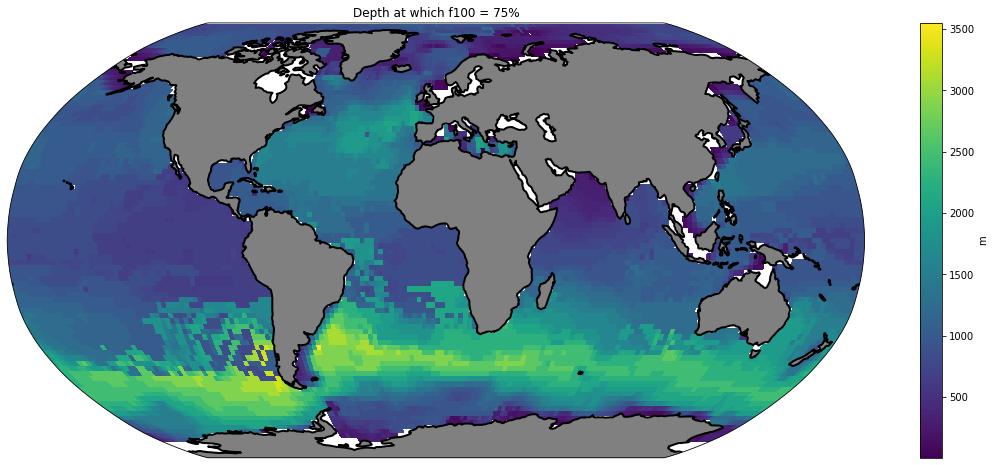

In [31]:
plot_map_simple((20,8), lonT, latT, depth_f100_75, None, None, 'Depth at which f100 = 75%', 'm', True, 'f100_75pc.jpg', mask)

In [32]:
weighted_mean_f100 = np.zeros(f100[:,:,0].shape)

for i, lat in enumerate(latT):
    for j, lon in enumerate(lonT):
        r = int(np.array(np.where(latT == lat))) # r for row
        c = int(np.array(np.where(lonT == lon))) # c for column
        zmax_pixel = zmax[r,c] # deepest depth of that pixel before reaching the sediment
        f100_wm = [] # f100 weighted mean (wm)
        deltaz_pixel = [] 
        for k, depth in enumerate(depthT):
            if np.isnan(zmax_pixel): # land pixel
                weighted_mean_f100[r,c] = np.nan
            elif depth == np.min(depthT): # case at the surface
                deltaz = (depthT[k]+depthT[k+1])/2
                deltaz_pixel.append(deltaz)
                f100_wm.append(f100[r,c,k] * deltaz)
            elif depth == zmax_pixel: # case at zmax_pixel
                deltaz = zmax_pixel - ((zmax_pixel+depthT[k-1])/2)
                deltaz_pixel.append(deltaz)
                f100_wm.append(f100[r,c,k] * deltaz)
                # compute weighted mean here, at zmax
                weighted_mean_f100[r,c] = (1/np.sum(np.array(deltaz_pixel)))*np.sum(np.array(f100_wm))
                break
            else:
                deltaz = ((depthT[k]+depthT[k+1])/2) - ((depthT[k-1]+depthT[k])/2)
                deltaz_pixel.append(deltaz)
                f100_wm.append(f100[r,c,k] * deltaz)

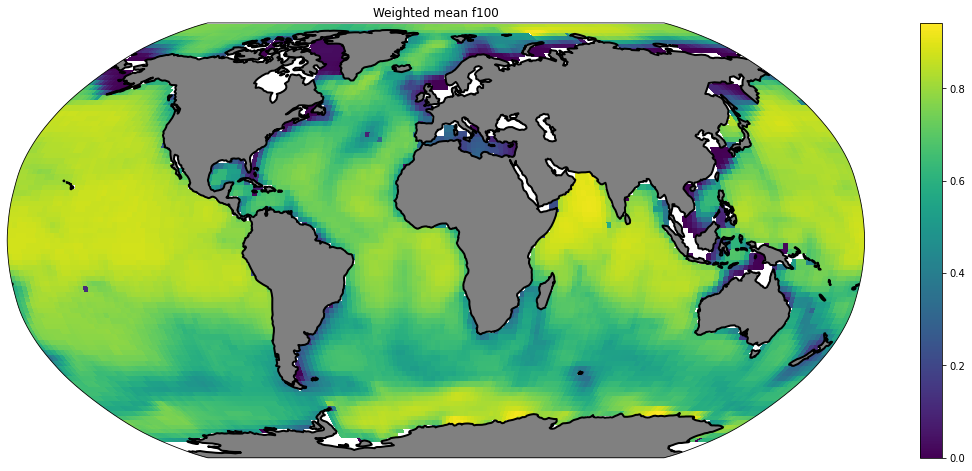

In [33]:
plot_map_simple((20,8), lonT, latT, weighted_mean_f100, None, None, 'Weighted mean f100', '', True, 'weighted_mean_f100.jpg', mask)

In [34]:
print(np.nanmax(weighted_mean_f100)) 
print(np.nanmedian(weighted_mean_f100))
print(np.nanmean(weighted_mean_f100))
print(np.nanmin(weighted_mean_f100))

0.9420513272068063
0.7072999606641636
0.6680893229567844
0.0


In [35]:
f100_weighted_above_median = np.copy(weighted_mean_f100)
f100_weighted_above_median = np.where(f100_weighted_above_median < np.nanmedian(weighted_mean_f100), np.nan, f100_weighted_above_median)

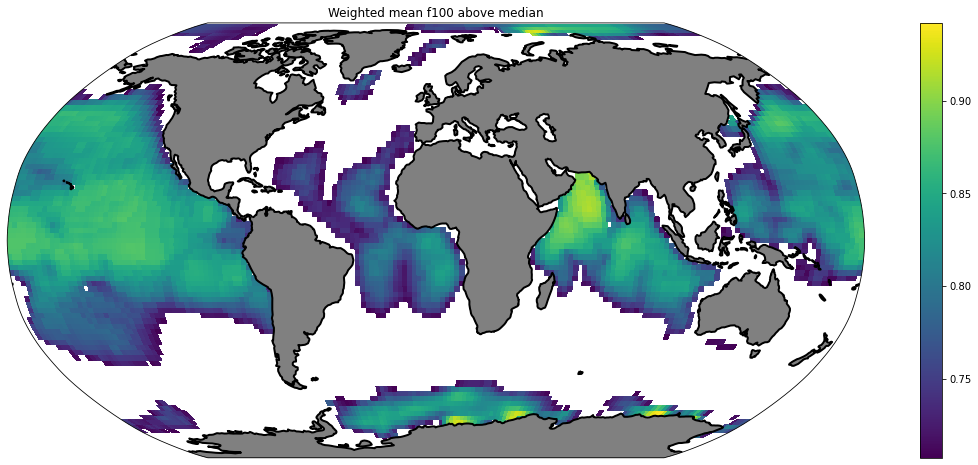

In [36]:
plot_map_simple((20,8), lonT, latT, f100_weighted_above_median, np.nanmedian(weighted_mean_f100), None, 'Weighted mean f100 above median', '', True, 'weighted_mean_f100_above_median.jpg', mask)

In [37]:
# f100 > 0.8
f100_weighted_above_08 = np.copy(weighted_mean_f100)
f100_weighted_above_08 = np.where(f100_weighted_above_08 < 0.8, np.nan, f100_weighted_above_08)

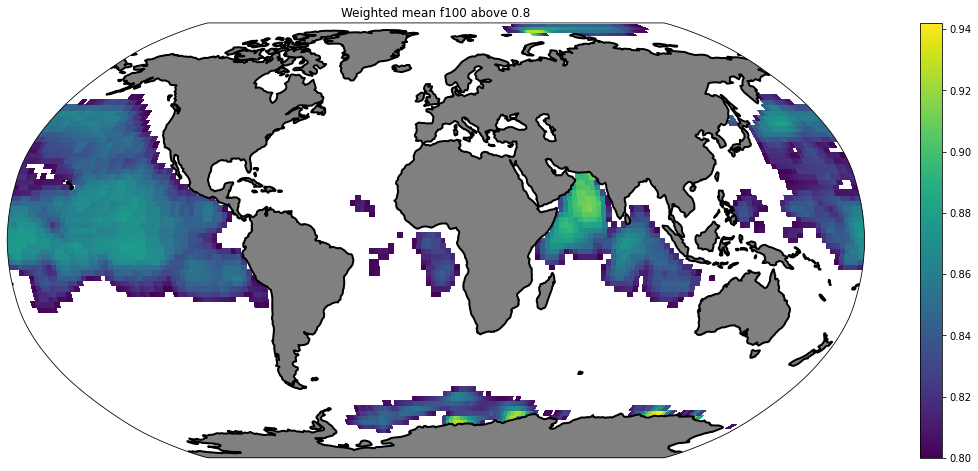

In [38]:
plot_map_simple((20,8), lonT, latT, f100_weighted_above_08, 0.8, None, 'Weighted mean f100 above 0.8', '', True, 'weighted_mean_f100_above_0.8.jpg', mask)

In [39]:
# f100 > 0.8
f100_weighted_below_05 = np.copy(weighted_mean_f100)
f100_weighted_below_05 = np.where(f100_weighted_below_05 > 0.5, np.nan, f100_weighted_below_05)

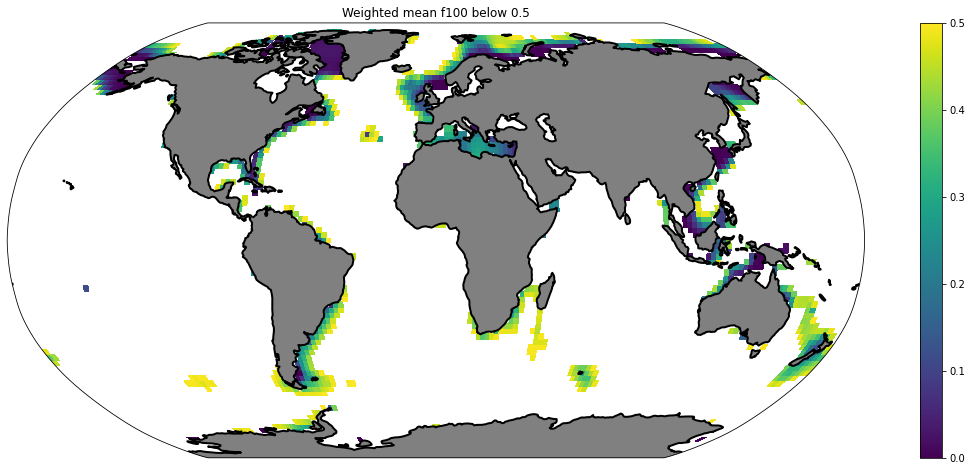

In [40]:
plot_map_simple((20,8), lonT, latT, f100_weighted_below_05, None, 0.5, 'Weighted mean f100 below 0.5', '', True, 'weighted_mean_f100_below_0.5.jpg', mask)

In [41]:
f100_weighted_lines = np.zeros(weighted_mean_f100.shape)
f100_weighted_lines = np.where(f100_weighted_above_median > 0.0, 1.0, f100_weighted_lines)

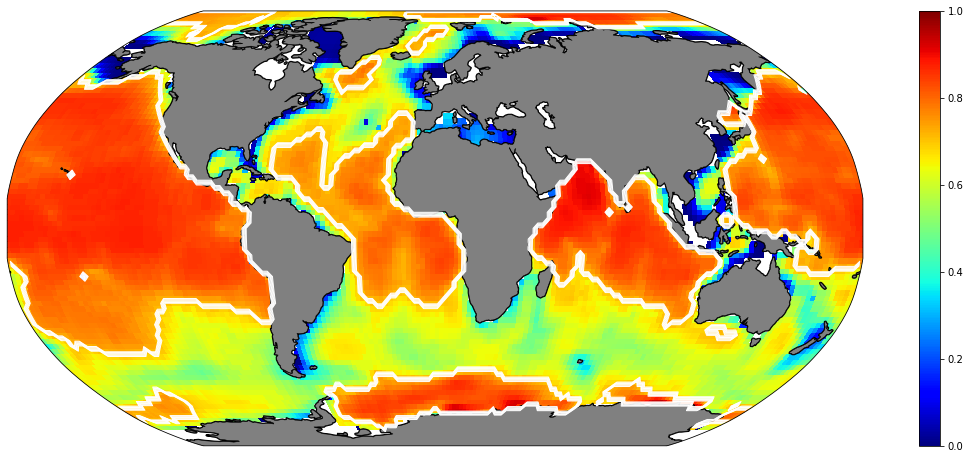

In [42]:
fig, ax = plt.subplots(1,1,figsize=(20,8),subplot_kw={'projection': ccrs.Robinson()})
ax.coastlines(resolution='110m', color='black', linestyle='-', alpha=1, linewidth = 2)
# p = ax.contourf(lonT, latT, weighted_mean_f100, shading = 'auto', 
#                  transform = ccrs.PlateCarree(), vmin = 0, vmax = 1)
p = ax.pcolormesh(lonT, latT, weighted_mean_f100, shading = 'auto', 
                 transform = ccrs.PlateCarree(), vmin = 0, vmax = 1, cmap = 'jet')
color_map = plt.cm.get_cmap('jet')
reversed_color_map = color_map.reversed()
# p = ax.pcolormesh(lonT, latT, weighted_mean_f100, shading = 'auto', 
#                  transform = ccrs.PlateCarree(), vmin = 0, vmax = 1, cmap = reversed_color_map)
ax.contour(lonT, latT, f100_weighted_lines, vmin = np.nanmedian(weighted_mean_f100),
                 transform = ccrs.PlateCarree(), colors = 'white', linewidths = 1)
ax.add_feature(land_110m)
#ax.set_title('Weighted mean f100')
cbar = plt.colorbar(p)
#cbar.set_label('[%]')
plt.savefig('./mapsV2/weighted_mean_with_contour_median.jpg')
plt.show()

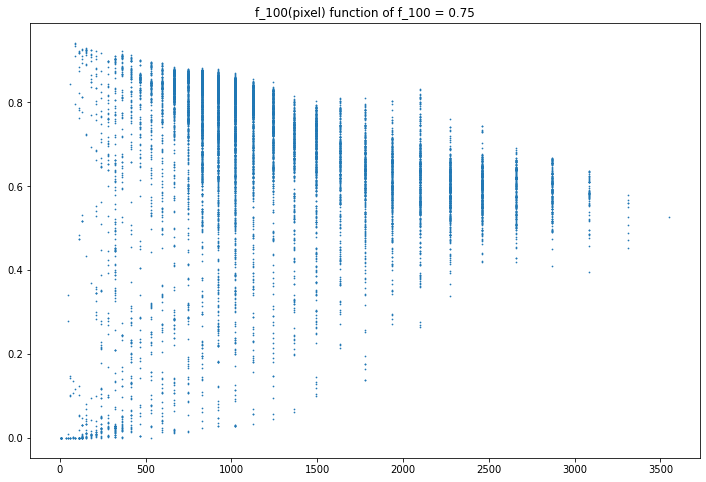

In [43]:
# dispersion f100_75% vs f100_averaged_pixel
plt.figure(figsize = (12,8))
plt.scatter(depth_f100_75.flatten(), weighted_mean_f100.flatten(), s = .5)
plt.title('f_100(pixel) function of f_100 = 0.75')
plt.savefig('./mapsV2/dispersion.jpg')
plt.show()

# Computation of the sequestered DOC flux based on SIMPLE-TRIM data

In [44]:
def add_matrix(A,B):
    """
    Function that deals with the issue of matrix addition with NaN (np.nansum(np.nan) == 0)
    This could potentially bias some average so it is important to be cautious when adding arrays with NaN.
    """
    matrix = np.where(np.isnan(A), B, A + np.nan_to_num(B))  
    return(matrix)

In [45]:
def compute_FseqDOC_ST(use_Zeu, DOCl, kl, DOCsl, ksl, DOCsr, ksr, DOCr, kr, latT = latT, lonT = lonT, f100_ST = f100_ST, deltaZ = deltaZ_matrix):

    FreminDOC = DOCl * kl * deltaZ # labile DOC, gC  m-2 y-1
    FreminDOC = add_matrix(FreminDOC, DOCsl * ksl * deltaZ) # semi-labile DOC, gC m-2 y-1
    FreminDOC = add_matrix(FreminDOC, DOCsr * ksr * deltaZ) # semi-refractory DOC, gC m-2 y-1
    FreminDOC = add_matrix(FreminDOC, DOCr * kr * deltaZ) # refractory DOC, gC m-2 y-1
    FseqDOC_ST = f100_ST * FreminDOC
 
    if use_Zeu == False: # Zexp = 100
        print('...not using Zeu...')
        FseqDOC_ST2 = np.nansum(FseqDOC_ST[:,:,3:], axis = 2)
        FseqDOC_ST2 = np.where(FseqDOC_ST2 == 0.0, np.nan, FseqDOC_ST2)
        
    else:
        print('...using Zeu...')
        Fseq_pixel = np.zeros(Zeu.shape)
        Fremin_pixel = np.zeros(Zeu.shape)
        for i, lat in enumerate(latT):
            for j, lon in enumerate(lonT):
                r = int(np.array(np.where(latT == lat))) # r for row
                c = int(np.array(np.where(lonT == lon))) # c for column
                Zeu_pixel = Zeu[r,c] # Euphotic depth for a pixel
                index_depth = np.argmax(Zeu_pixel - depthST < 0)
                Fseq_pixel[r,c] = np.nansum(FseqDOC_ST[r,c,index_depth:])
                FseqDOC_ST2 = np.where(Fseq_pixel == 0.0, np.nan, Fseq_pixel) 
    
    return(FreminDOC, FseqDOC_ST, FseqDOC_ST2)

# Computation of FseqPOC using modeled carbon fluxes from SIMPLE-TRIM

In [46]:
JreminPOC_slow = np.zeros((12,91,180,24))
for v in range(12):
    for i, lat in enumerate(latT):
        for j, lon in enumerate(lonT):
            r = int(np.array(np.where(latT == lat))) # r for row
            c = int(np.array(np.where(lonT == lon))) 
            for k, depth in enumerate(depthST):
                JreminPOC_slow[v,r,c,k] = (kslow[v]*(q10[v]**((temp[r,c,k]-Tref)/10)))*(o2_obs[r,c,k]/(o2_obs[r,c,k]+Ko2[v]))*POCslow[v,r,c,k]

JreminPOC_fast = np.zeros((12,91,180,24))
for v in range(12):
    for i, lat in enumerate(latT):
        for j, lon in enumerate(lonT):
            r = int(np.array(np.where(latT == lat))) # r for row
            c = int(np.array(np.where(lonT == lon))) 
            for k, depth in enumerate(depthST):
                JreminPOC_fast[v,r,c,k] = (kfast[v]*(q10[v]**((temp[r,c,k]-Tref)/10)))*(o2_obs[r,c,k]/(o2_obs[r,c,k]+Ko2[v]))*POCfast[v,r,c,k]

In [47]:
def compute_FseqPOC_ST(use_Zeu, version, latT = latT, lonT = lonT, f100_ST = f100_ST, depthST = depthST, JreminPOC_slow = JreminPOC_slow, JreminPOC_fast = JreminPOC_fast, deltaZ = deltaZ_matrix):
    
    FreminPOC_slow = JreminPOC_slow[version,:,:,:] * deltaZ # gC m-2 y-1
    FreminPOC_fast = JreminPOC_fast[version,:,:,:] * deltaZ # gC m-2 y-1
    FreminPOC = add_matrix(FreminPOC_slow, FreminPOC_fast) # gC m-2 y-1
    FseqPOC_ST = FreminPOC * f100_ST # gC m-2 y-1   
    
    if use_Zeu == False: # Zexp = 100
        print('...not using Zeu...')
        FseqPOC_ST2 = np.nansum(FseqPOC_ST[:,:,3:], axis = 2)
        FseqPOC_ST2 = np.where(FseqPOC_ST2 == 0.0, np.nan, FseqPOC_ST2)
        
    else:
        print('...using Zeu...')
        Fseq_pixel = np.zeros(Zeu.shape)
        Fremin_pixel = np.zeros(Zeu.shape)
        for i, lat in enumerate(latT):
            for j, lon in enumerate(lonT):
                r = int(np.array(np.where(latT == lat))) # r for row
                c = int(np.array(np.where(lonT == lon))) # c for column
                Zeu_pixel = Zeu[r,c] # Euphotic depth for a pixel
                index_depth = np.argmax(Zeu_pixel - depthST < 0)
                Fseq_pixel[r,c] = np.nansum(FseqPOC_ST[r,c,index_depth:])
                FseqPOC_ST2 = np.where(Fseq_pixel == 0.0, np.nan, Fseq_pixel) 
    
    return(FreminPOC, FseqPOC_ST, FseqPOC_ST2)

In [48]:
# i = 0
# a,b,c = compute_FseqPOC_ST(False, i)
# compute_flux_total(c, pixelArea)

# Computation of FseqMigr

# Daily

In [49]:
# compute North Atlantic Mask /!\ TO BE IMPROVED (with more precise coordinates)
mask_index = []
maskNorthAtl = np.zeros(FexpH.shape)

lat_Jonasdottir = np.argwhere((latT >= 55) & (latT <= 70)) 
lon_Jonasdottir = np.argwhere((lonT >= -60) & (lonT <= 10))

for i in lat_Jonasdottir:
    for j in lon_Jonasdottir:
        tmp = (int(i),int(j))
        mask_index.append(tmp)
        
# compute mask
for coord in mask_index:
    maskNorthAtl[coord] = 1.0

maskNorthAtl = np.where(maskNorthAtl != 1.0, np.nan, maskNorthAtl)

In [50]:
def compute_FmigrD(Fexp_matrix, f100 = f100):
    # daily migration
    FreminMigrD = 0.25 * Fexp_matrix
    FseqMigrD = FreminMigrD * f100[:,:,15]
    
    return(FreminMigrD, FseqMigrD)

# Seasonally 

In [51]:
def compute_FluxC(z, b, Fexp, Zexp):
    Flux = Fexp * (z/Zexp)**b 
    return(Flux)

In [52]:
def compute_Fseq_migr_seasonal(b_matrix, Fexp_matrix, Zexp_matrix, POCflux, use_ST = False, latT = latT, lonT = lonT, mask = maskNorthAtl, zmax = zmax, depthT = depthT, f100 = f100):
    
    Flux_migr_season = np.zeros(Fexp_matrix.shape)
    
    for i, lat in enumerate(latT):
        for j, lon in enumerate(lonT):
            r = int(np.array(np.where(latT == lat))) # r for row
            c = int(np.array(np.where(lonT == lon))) # c for column
            zmax_pixel = zmax[r,c] # deepest depth of that pixel before reaching the sediment
            b = b_matrix[r,c] # for the paper, we'll only use this. Maybe Lionel's or Henson's for supp. material
            Fexp = Fexp_matrix[r,c]
            Zexp = Zexp_matrix[r,c]
            depth = depthT[20]
            if np.isnan(zmax_pixel): # land pixel
                Flux_migr_season[r,c] = np.nan
            elif depth >= zmax_pixel: # shallow pixel for seasonal migration flux
                Flux_migr_season[r,c] = np.nan
            else:
                if use_ST == False:
                    Flux_z = compute_FluxC(depth, b, Fexp, Zexp)
                    Flux_migr_season[r,c] = Flux_z
                else:
                    Flux_z = POCflux[r,c,9] # 619m
                    Flux_migr_season[r,c] = Flux_z
        
    Fremin = 0.5 * Flux_migr_season * mask
    Fseq = Fremin * f100[:,:,20]
    
    return(Fremin, Fseq)

# Computation of FseqTop

In [53]:
def compute_FseqTop(FprodPOC, FexpDOC, FexpPOC, FexpMigrD, FexpMigrS, f100_Top_layer):
    
    Fexp_POC_DOC = add_matrix(FexpPOC, FexpDOC)
    Fexp_POC_DOC_MigrD = add_matrix(Fexp_POC_DOC, FexpMigrD)
    Fexp_POC_DOC_MigrD_MigrS = add_matrix(Fexp_POC_DOC_MigrD, FexpMigrS)
    
    FreminTop = add_matrix(FprodPOC, -Fexp_POC_DOC_MigrD_MigrS) # add the - sign to compute the difference between the matrices
    
    FseqTop = FreminTop * f100_Top_layer
    
    return(FreminTop, FseqTop)

# Computation of FseqTop when using directly ST's concentrations/flux at depth

In [54]:
def compute_FseqTop_ST(FreminPOC, FreminDOC, use_Zeu, f100 = f100_ST, latT = latT, lonT = lonT, Zeu = Zeu):
    
    if use_Zeu == False:
        FreminTotal = add_matrix(FreminPOC[:,:,:3], FreminDOC[:,:,:3]) # layer until 100m (115m)
        FseqTop = FreminTotal * f100[:,:,:3]
        FseqTop = np.nansum(FseqTop, axis = 2)
        FseqTop = np.where(FseqTop == 0.0, np.nan, FseqTop)
    else:
        FseqTop = np.zeros(Zeu.shape)
        FreminTotal = add_matrix(FreminPOC, FreminDOC)
        for i, lat in enumerate(latT):
            for j, lon in enumerate(lonT):
                r = int(np.array(np.where(latT == lat))) # r for row
                c = int(np.array(np.where(lonT == lon))) # c for column
                Zeu_pixel = Zeu[r,c] # Euphotic depth for a pixel
                index_depth = np.argmax(Zeu_pixel - depthST < 0)
                tmp = FreminTotal[r,c,:index_depth] * f100[r,c,:index_depth]
                tmp = np.nansum(tmp)
                FseqTop[r,c] = tmp
        FseqTop = np.where(FseqTop == 0.0, np.nan, FseqTop)
    
    return(FseqTop)

# Compute FexpDOC based on ST DOC fluxes

In [55]:
def compute_FexpDOC(DOCl, DOCsl, DOCsr, DOCr, FexpT, depthST = depthST, FexpH = FexpH, deltaZ = deltaZ_matrix, pixelArea = pixelArea):
    
    FluxDOC = DOCl  # first, the labile DOC
    FluxDOC = add_matrix(FluxDOC, DOCsl) # add semi-labile DOC
    FluxDOC = add_matrix(FluxDOC, DOCsr) # add semi-refractory DOC
    FluxDOC = add_matrix(FluxDOC, DOCr) # add refractory DOC
    
    # Fexp(S-T, Zexp = 100m) # technically we are at 115m
    for i, lat in enumerate(latT):
        for j, lon in enumerate(lonT):
            r = int(np.array(np.where(latT == lat))) # r for row
            c = int(np.array(np.where(lonT == lon)))
            FexpDOC_ST = FluxDOC[r,c,4] * deltaZ[r,c,4] 
    
    # FexpDOC_Henson
    ratio_export_global = compute_flux_total(FexpH, pixelArea)/compute_flux_total(FexpT, pixelArea)

    FexpDOC_H = FexpDOC_ST * ratio_export_global
    
    return(FexpDOC_H, FexpDOC_ST)

# OLD WAY TO COMPUTE FseqDOC

In [56]:
def compute_FseqDOC_v1(Fexp, f100_matrix):
#def compute_FseqDOC_pixel(coarser_export, pc_co2, f100_surface_layer):
    
    FreminDOC = 0.25 * Fexp
    FseqDOC = FreminDOC * f100_matrix[:,:,19]
    
    return(FseqDOC)

# RESULTS

In [57]:
def printResult(FseqPOC, FseqDOC, FseqMigrD, FseqMigrS, FseqTop, pixel_areas, mask):
    
    print('Global Fseq(POC):', np.round(compute_flux_total(FseqPOC*mask, pixel_areas),2), ' GtC/year'),
    print('Global Fseq(DOC):', np.round(compute_flux_total(FseqDOC*mask, pixel_areas),2), ' GtC/year')
    print('Global Fseq(Migr Diel):', np.round(compute_flux_total(FseqMigrD*mask, pixel_areas),2), ' GtC/year')
    print('Global Fseq(Migr Season):', np.round(compute_flux_total(FseqMigrS*mask, pixel_areas),3), ' GtC/year')
    print('Global Fseq(Top):', np.round(compute_flux_total(FseqTop*mask, pixel_areas),2), ' GtC/year')
    print('Global BCPs:', np.round(np.sum(np.array([compute_flux_total(FseqPOC*mask, pixel_areas),
                                compute_flux_total(FseqDOC*mask, pixel_areas),
                                compute_flux_total(FseqMigrD*mask, pixel_areas),
                                compute_flux_total(FseqMigrS*mask, pixel_areas),
                                compute_flux_total(FseqTop*mask, pixel_areas)])),2), 'GtC/year')

In [58]:
def printResult_mean_median(FseqPOC, FseqDOC, FseqMigrD, FseqMigrS, FseqTop, pixel_areas, mask):
    
    totalBCP = add_matrix(FseqPOC, FseqDOC)
    totalBCP = add_matrix(totalBCP, FseqMigrD)
    totalBCP = add_matrix(totalBCP, FseqMigrS)
    totalBCP = add_matrix(totalBCP, FseqTop)
    
    print('MEDIAN VALUES')
    print('Median Fseq(POC):', np.round(np.nanmedian(FseqPOC*mask),2), ' gC/m2/year'),
    print('Median Fseq(DOC):', np.round(np.nanmedian(FseqDOC*mask),2), ' gC/m2/year')
    print('Median Fseq(Migr Diel):', np.round(np.nanmedian(FseqMigrD*mask),2), ' gC/m2/year')
    print('Median Fseq(Migr Season):', np.round(np.nanmedian(FseqMigrS*mask),2), ' gC/m2/year')
    print('Median Fseq(Top):', np.round(np.nanmedian(FseqTop*mask),2), ' gC/m2/year')
    print('Median BCPs:', np.round(np.nanmedian(totalBCP*mask),2), 'gC/m2/year')
    print('\nMEAN VALUES')
    print('Mean Fseq(POC):', np.round(np.nanmean(FseqPOC*mask),2), ' gC/m2/year'),
    print('Mean Fseq(DOC):', np.round(np.nanmean(FseqDOC*mask),2), ' gC/m2/year')
    print('Mean Fseq(Migr Diel):', np.round(np.nanmean(FseqMigrD*mask),2), ' gC/m2/year')
    print('Mean Fseq(Migr Season):', np.round(np.nanmean(FseqMigrS*mask),2), ' gC/m2/year')
    print('Mean Fseq(Top):', np.round(np.nanmean(FseqTop*mask),2), ' gC/m2/year')
    print('Mean BCPs:', np.round(np.nanmean(totalBCP*mask),2), 'gC/m2/year')
    
    return(totalBCP)

In [59]:
def printResult_ratio_reference(FseqPOC, FseqDOC, FseqMigrD, FseqMigrS, FseqTop, pixel_areas, mask, FexpReference, use_ST = False):
    
    if use_ST == False:
        reference = compute_flux_total(FexpReference, pixel_areas)
    else:
        reference = compute_flux_total_mean(FexpReference, pixel_areas) # no mask because FexpH ~ 4GtC/year and it's a kind of reference (if we use the mask, we would have ~3.3-3.4 PgC y-1)
    
    print('Global Fexp:', np.round(reference, 2), 'GtC/year')
    print('Global F*seq(POC):', np.round(compute_flux_total(FseqPOC*mask, pixel_areas)/reference,2))
    print('Global F*seqBCPs:', np.round(np.sum(np.array([compute_flux_total(FseqPOC*mask, pixel_areas),
                                compute_flux_total(FseqDOC*mask, pixel_areas),
                                compute_flux_total(FseqMigrD*mask, pixel_areas),
                                compute_flux_total(FseqMigrS*mask, pixel_areas),
                                compute_flux_total(FseqTop*mask, pixel_areas)]))/reference,2))

In [60]:
def compute_pixel_area(pixel_area, data, mask):
    map_data = data*mask # masked data with mask of > 100m 
    total_pixel_number = map_data.shape[0]*map_data.shape[1] # total number of pixels (resolution in fine)
    pixel_defined = ~np.isnan(map_data)
    number_pixel_defined = np.sum(~np.isnan(map_data))
    covered_area = np.sum(pixelArea[pixel_defined])/1e12 # km2
    
    return(number_pixel_defined, covered_area)

In [61]:
def compute_pixel_area_version(FseqPOC, FseqDOC, FseqMigrD, FseqMigrS, FseqTop, FseqBCPs, FseqPOC2000, pixelArea, mask):
    print('FseqPOC pixel + area:', compute_pixel_area(pixelArea, FseqPOC, mask))
    print('FseqDOC pixel + area:', compute_pixel_area(pixelArea, FseqDOC, mask))
    print('FseqMigrD pixel + area:', compute_pixel_area(pixelArea, FseqMigrD, mask))
    print('FseqMigrS pixel + area:', compute_pixel_area(pixelArea, FseqMigrS, mask))
    print('FseqTop pixel + area:', compute_pixel_area(pixelArea, FseqTop, mask))
    print('FseqBCPs pixel + area:', compute_pixel_area(pixelArea, FseqBCPs, mask))
    print('Fseq2000m pixel + area:', compute_pixel_area(pixelArea, FseqPOC2000, mask))

In [62]:
def compute_min_max_median_FreminMigrS(FreminMigrS):
    min_val = np.nanmin(FreminMigrS)
    max_val = np.nanmax(FreminMigrS)
    median_val = np.nanmedian(FreminMigrS)
    return(min_val, max_val, median_val)

# Table S2 and Figure S3

### For FexpHenson and Zexp = 100

In [63]:
# POC below Zexp (Top)
FreminPOC_H_water_100m, FseqPOC_H_water_100m = compute_sequestration_in_water(zmax, depthT, b_martin, f100, FexpH, ZexpH)
FseqPOC_H_sed_100m = compute_sequestration_in_sediment(zmax, b_martin, FexpH, ZexpH)
FseqPOC_H_100m = compute_Fseq_pixel_below_Top(FseqPOC_H_sed_100m, FseqPOC_H_water_100m)

# DOC below Top - v1
FseqDOC_H_100m = compute_FseqDOC_v1(FexpH, f100) # old version for table S2

# Migration Daily
FreminMigrD_H_100m, FseqMigrD_H_100m = compute_FmigrD(FexpH)

# Migration Seasonally
FreminMigrS_H_100m = np.zeros((12,91,180))
FseqMigrS_H_100m = np.zeros((12,91,180))
for i in range(12):
    FreminMigrS_H_100m[i,:,:], FseqMigrS_H_100m[i,:,:] = compute_Fseq_migr_seasonal(b_martin, FexpH, ZexpH, POCflux[i,:,:,:], False)
# average
FreminMigrS_H_100m = np.nanmean(FreminMigrS_H_100m, axis = 0)
FseqMigrS_H_100m = np.nanmean(FseqMigrS_H_100m, axis = 0)

# compute FexpDOC
FexpDOC_H_100m = np.zeros((12,91,180))
FexpDOC_ST_100m = np.zeros((12,91,180))
for i in range(12):
    FexpDOC_H_100m[i,:,:], FexpDOC_ST_100m[i,:,:] = compute_FexpDOC(DOCl[i,:,:,:], DOCsl[i,:,:,:], DOCsr[i,:,:,:], DOCr[i,:,:,:], FexpT[i,:,:])
# average
FexpDOC_H_100m = np.nanmean(FexpDOC_H_100m, axis = 0)

# Top layer
FreminTop_H_100m, FseqTop_H_100m = compute_FseqTop(ppH, FexpDOC_H_100m, FexpH, FreminMigrD_H_100m, FreminMigrS_H_100m, f100_Top)

# Fseq(2000m)
FseqPOC2000m_martin = np.zeros((12,91,180))
for i in range(12):
    FseqPOC2000m_martin[i,:,:] = compute_FseqPOC_2000m(b_martin, FexpH, ZexpH, POCflux[i,:,:,:])
FseqPOC2000m_martin = np.nanmean(FseqPOC2000m_martin, axis = 0)

<ipython-input-63-e7015b099d68>:18: RuntimeWarning: Mean of empty slice
  FreminMigrS_H_100m = np.nanmean(FreminMigrS_H_100m, axis = 0)
<ipython-input-63-e7015b099d68>:19: RuntimeWarning: Mean of empty slice
  FseqMigrS_H_100m = np.nanmean(FseqMigrS_H_100m, axis = 0)
<ipython-input-63-e7015b099d68>:27: RuntimeWarning: Mean of empty slice
  FexpDOC_H_100m = np.nanmean(FexpDOC_H_100m, axis = 0)
<ipython-input-63-e7015b099d68>:36: RuntimeWarning: Mean of empty slice
  FseqPOC2000m_martin = np.nanmean(FseqPOC2000m_martin, axis = 0)


In [64]:
# print results
printResult(FseqPOC_H_100m, FseqDOC_H_100m, FseqMigrD_H_100m, FseqMigrS_H_100m, FseqTop_H_100m, pixelArea, mask)
print('')
# with ratio reference
printResult_ratio_reference(FseqPOC_H_100m, FseqDOC_H_100m, FseqMigrD_H_100m, FseqMigrS_H_100m, FseqTop_H_100m, pixelArea, mask, FexpH)
print('')
FseqBCPs_H_100m = printResult_mean_median(FseqPOC_H_100m, FseqDOC_H_100m, FseqMigrD_H_100m, FseqMigrS_H_100m, FseqTop_H_100m, pixelArea, mask)
print('\nSequestration flux at 2000 m:', np.round(compute_flux_total(FseqPOC2000m_martin*mask, pixelArea), 2))
ref = compute_flux_total(FexpH, pixelArea)
print('F*seq(2000):', np.round(compute_flux_total(FseqPOC2000m_martin*mask, pixelArea)/ref, 2))

min_valMigrS, max_valMigrS, median_valMigrS = compute_min_max_median_FreminMigrS(FreminMigrS_H_100m)
print('\nValues min/max/median for FseqMigrS:')
print('Min: ', np.round(min_valMigrS, 2))
print('Max: ', np.round(max_valMigrS, 2))
print('Median: ', np.round(median_valMigrS, 2))

Global Fseq(POC): 0.74  GtC/year
Global Fseq(DOC): 0.22  GtC/year
Global Fseq(Migr Diel): 0.11  GtC/year
Global Fseq(Migr Season): 0.004  GtC/year
Global Fseq(Top): 0.29  GtC/year
Global BCPs: 1.36 GtC/year

Global Fexp: 4.05 GtC/year
Global F*seq(POC): 0.18
Global F*seqBCPs: 0.33

MEDIAN VALUES
Median Fseq(POC): 1.66  gC/m2/year
Median Fseq(DOC): 0.49  gC/m2/year
Median Fseq(Migr Diel): 0.21  gC/m2/year
Median Fseq(Migr Season): 1.02  gC/m2/year
Median Fseq(Top): 0.04  gC/m2/year
Median BCPs: 2.68 gC/m2/year

MEAN VALUES
Mean Fseq(POC): 2.37  gC/m2/year
Mean Fseq(DOC): 0.68  gC/m2/year
Mean Fseq(Migr Diel): 0.37  gC/m2/year
Mean Fseq(Migr Season): 0.93  gC/m2/year
Mean Fseq(Top): 0.83  gC/m2/year
Mean BCPs: 4.24 gC/m2/year

Sequestration flux at 2000 m: 0.19
F*seq(2000): 0.05

Values min/max/median for FseqMigrS:
Min:  0.69
Max:  3.67
Median:  1.97


In [65]:
compute_pixel_area_version(FseqPOC_H_100m, FseqDOC_H_100m, FseqMigrD_H_100m, FseqMigrS_H_100m, FseqTop_H_100m, FseqBCPs_H_100m, FseqPOC2000m_martin, pixelArea, mask)

FseqPOC pixel + area: (9235, 343.60638433698176)
FseqDOC pixel + area: (8931, 336.8577215110956)
FseqMigrD pixel + area: (9072, 340.1940115804165)
FseqMigrS pixel + area: (205, 4.696420385705691)
FseqTop pixel + area: (9238, 343.6552228630314)
FseqBCPs pixel + area: (9238, 343.6552228630314)
Fseq2000m pixel + area: (7952, 308.33030463063744)


In [66]:
# SAVE DATA FOR FIG S3

# ATTENTION FOR NEGATIVE VALUES OR VERY SMALL VALUES, WE PUT THEM AT THE SCALE MINIMUM
FseqDOC_H_100m = np.where(FseqDOC_H_100m<1e-3, 1e-3, FseqDOC_H_100m) 
FseqTop_H_100m = np.where(FseqTop_H_100m<1e-3, 1e-3, FseqTop_H_100m)

plot_map((20,8), lonT, latT, FseqPOC_H_100m, 1e-3, 1e2, '', '', True, 'FseqPOC.jpg', mask, cmap = 'jet', folder = './FigS3/Export_H_100m/', plt_show = False, use_log_scale = True, use_colorbar = False)
plot_map((20,8), lonT, latT, FseqDOC_H_100m, 1e-3, 1e2, '', '', True, 'FseqDOC.jpg', mask, cmap = 'jet', folder = './FigS3/Export_H_100m/', plt_show = False, use_log_scale = True, use_colorbar = False)
plot_map((20,8), lonT, latT, FseqMigrD_H_100m, 1e-3, 1e2, '', '', True, 'FseqMigrD.jpg', mask, cmap = 'jet', folder = './FigS3/Export_H_100m/', plt_show = False, use_log_scale = True, use_colorbar = False)
plot_map((20,8), lonT, latT, FseqMigrS_H_100m, 1e-3, 1e2, '', '', True, 'FseqMigrS.jpg', mask, cmap = 'jet', folder = './FigS3/Export_H_100m/', plt_show = False, use_log_scale = True, use_colorbar = False)
plot_map((20,8), lonT, latT, FseqTop_H_100m, 1e-3, 1e2, '', '', True, 'FseqTop.jpg', mask, cmap = 'jet', folder = './FigS3/Export_H_100m/', plt_show = False, use_log_scale = True, use_colorbar = False)
plot_map((20,8), lonT, latT, FseqBCPs_H_100m, 1e-3, 1e2, '', '', True, 'FseqBCPs.jpg', mask, cmap = 'jet', folder = './FigS3/Export_H_100m/', plt_show = False, use_log_scale = True, use_colorbar = False)
plot_map((20,8), lonT, latT, FseqPOC2000m_martin, 1e-3, 1e2, '', '', True, 'FseqPOC2000m.jpg', mask, cmap = 'jet', folder = './FigS3/Export_H_100m/', plt_show = False, use_log_scale = True, use_colorbar = False)

In [67]:
# SAVE DATA FOR FIG 4
plot_map((20,8), lonT, latT, FseqPOC_H_100m, 1e-3, 1e2, 'F$_{seq}$ = '+str(np.round(compute_flux_total(FseqPOC_H_100m*mask, pixelArea), 2))+' Pg C y$^{-1}$   F$^{*}_{seq}$ = '+str(np.round(compute_flux_total(FseqPOC_H_100m*mask, pixelArea)/ref, 2)), '', True, 'FseqPOC.jpg', mask, cmap = 'jet', folder = './Fig4/Export_H_100m_martin/', plt_show = False, use_log_scale = True, use_colorbar = False)
plot_map((20,8), lonT, latT, FseqBCPs_H_100m, 1e-3, 1e2, 'F$_{seq}$ = '+str(np.round(compute_flux_total(FseqBCPs_H_100m*mask, pixelArea), 2))+' Pg C y$^{-1}$   F$^{*}_{seq}$ = '+str(np.round(compute_flux_total(FseqBCPs_H_100m*mask, pixelArea)/ref, 2)), '', True, 'FseqBCPs.jpg', mask, cmap = 'jet', folder = './Fig4/Export_H_100m_martin/', plt_show = False, use_log_scale = True, use_colorbar = False)
plot_map((20,8), lonT, latT, FseqPOC2000m_martin, 1e-3, 1e2, 'F$_{seq}$ = '+str(np.round(compute_flux_total(FseqPOC2000m_martin*mask, pixelArea), 2))+' Pg C y$^{-1}$   F$^{*}_{seq}$ = '+str(np.round(compute_flux_total(FseqPOC2000m_martin*mask, pixelArea)/ref, 2)), '', True, 'FseqPOC2000m.jpg', mask, cmap = 'jet', folder = './Fig4/Export_H_100m_martin/', plt_show = False, use_log_scale = True, use_colorbar = False)

### For FexpTim_100 and Zexp = 100 m

In [68]:
# POC below Zexp (Top)
FreminPOC_ST_100m_full_matrix = np.zeros((12,91,180,24))
FseqPOC_ST_100m_full_matrix = np.zeros((12,91,180,24))
FseqPOC_ST_100m = np.zeros((12,91,180))
for i in range(12):
    FreminPOC_ST_100m_full_matrix[i,:,:,:], FseqPOC_ST_100m_full_matrix[i,:,:,:], FseqPOC_ST_100m[i,:,:] = compute_FseqPOC_ST(False, i)
FseqPOC_ST_100m = np.nanmean(FseqPOC_ST_100m, axis = 0)

# DOC
FreminDOC_ST_100m_full_matrix = np.zeros((12,91,180,24))
FseqDOC_ST_100m_full_matrix = np.zeros((12,91,180,24))
FseqDOC_ST_100m = np.zeros((12,91,180))
for i in range(12):
    FreminDOC_ST_100m_full_matrix[i,:,:,:], FseqDOC_ST_100m_full_matrix[i,:,:,:], FseqDOC_ST_100m[i,:,:] = compute_FseqDOC_ST(False, DOCl[i,:,:,:], kl[i], DOCsl[i,:,:,:], ksl[i], DOCsr[i,:,:,:], ksr[i], DOCr[i,:,:,:], kr[i])
FseqDOC_ST_100m = np.nanmean(FseqDOC_ST_100m, axis = 0)

# Migration D
FreminMigrD_ST_100m = np.zeros((12,91,180))
FseqMigrD_ST_100m = np.zeros((12,91,180))
for i in range(12):
    FreminMigrD_ST_100m[i,:,:], FseqMigrD_ST_100m[i,:,:] = compute_FmigrD(FexpT[i,:,:])
FreminMigrD_ST_100m = np.nanmean(FreminMigrD_ST_100m, axis = 0)
FseqMigrD_ST_100m = np.nanmean(FseqMigrD_ST_100m, axis = 0)

# Migration Seasonally
FreminMigrS_ST_100m = np.zeros((12,91,180))
FseqMigrS_ST_100m = np.zeros((12,91,180))
for i in range(12):
    FreminMigrS_ST_100m[i,:,:], FseqMigrS_ST_100m[i,:,:] = compute_Fseq_migr_seasonal(b_martin, FexpT[i,:,:], ZexpH, POCflux[i,:,:,:], True)
FreminMigrS_ST_100m = np.nanmean(FreminMigrS_ST_100m, axis = 0)
FseqMigrS_ST_100m = np.nanmean(FseqMigrS_ST_100m, axis = 0)

# Top layer
FseqTop_ST_100m = np.zeros((12,91,180))
for i in range(12):
    FseqTop_ST_100m = compute_FseqTop_ST(FreminPOC_ST_100m_full_matrix[i,:,:,:], FreminDOC_ST_100m_full_matrix[i,:,:,:], False)
FseqTop_ST_100m = np.nanmean(FseqTop_ST_100m, axis = 0)

# Fseq(2000)
FseqPOC2000m_ST = np.zeros((12,91,180))
for i in range(12):
    FseqPOC2000m_ST[i,:,:] = compute_FseqPOC_2000m(b_guidi, FexpT[i,:,:], ZexpH, POCflux[i,:,:,:], use_ST = True) # in that case, we only need use_ST, actually...
FseqPOC2000m_ST = np.nanmean(FseqPOC2000m_ST, axis = 0)

...not using Zeu...
...not using Zeu...
...not using Zeu...
...not using Zeu...
...not using Zeu...
...not using Zeu...
...not using Zeu...
...not using Zeu...
...not using Zeu...
...not using Zeu...
...not using Zeu...
...not using Zeu...
...not using Zeu...
...not using Zeu...
...not using Zeu...


<ipython-input-68-2396b71509dd>:7: RuntimeWarning: Mean of empty slice
  FseqPOC_ST_100m = np.nanmean(FseqPOC_ST_100m, axis = 0)


...not using Zeu...
...not using Zeu...
...not using Zeu...
...not using Zeu...
...not using Zeu...
...not using Zeu...
...not using Zeu...
...not using Zeu...
...not using Zeu...


<ipython-input-68-2396b71509dd>:15: RuntimeWarning: Mean of empty slice
  FseqDOC_ST_100m = np.nanmean(FseqDOC_ST_100m, axis = 0)
<ipython-input-68-2396b71509dd>:22: RuntimeWarning: Mean of empty slice
  FreminMigrD_ST_100m = np.nanmean(FreminMigrD_ST_100m, axis = 0)
<ipython-input-68-2396b71509dd>:23: RuntimeWarning: Mean of empty slice
  FseqMigrD_ST_100m = np.nanmean(FseqMigrD_ST_100m, axis = 0)
<ipython-input-68-2396b71509dd>:30: RuntimeWarning: Mean of empty slice
  FreminMigrS_ST_100m = np.nanmean(FreminMigrS_ST_100m, axis = 0)
<ipython-input-68-2396b71509dd>:31: RuntimeWarning: Mean of empty slice
  FseqMigrS_ST_100m = np.nanmean(FseqMigrS_ST_100m, axis = 0)
<ipython-input-68-2396b71509dd>:43: RuntimeWarning: Mean of empty slice
  FseqPOC2000m_ST = np.nanmean(FseqPOC2000m_ST, axis = 0)


In [69]:
# print results
printResult(FseqPOC_ST_100m, FseqDOC_ST_100m, FseqMigrD_ST_100m, FseqMigrS_ST_100m, FseqTop_ST_100m, pixelArea, mask)
# print results
print('')
printResult_ratio_reference(FseqPOC_ST_100m, FseqDOC_ST_100m, FseqMigrD_ST_100m, FseqMigrS_ST_100m, FseqTop_ST_100m, pixelArea, mask, FexpT, use_ST = True)
print('')
FseqBCPs_ST_100m = printResult_mean_median(FseqPOC_ST_100m, FseqDOC_ST_100m, FseqMigrD_ST_100m, FseqMigrS_ST_100m, FseqTop_ST_100m, pixelArea, mask)

print('\nSequestration flux at 2000 m:', np.round(compute_flux_total(FseqPOC2000m_ST*mask, pixelArea), 2))
ref = compute_flux_total_mean(FexpT, pixelArea)
print('F*seq(2000):', np.round(compute_flux_total(FseqPOC2000m_ST*mask, pixelArea)/ref, 2))

min_valMigrS, max_valMigrS, median_valMigrS = compute_min_max_median_FreminMigrS(FreminMigrS_ST_100m)
print('\nValues min/max/median for FseqMigrS:')
print('Min: ', np.round(min_valMigrS, 2))
print('Max: ', np.round(max_valMigrS, 2))
print('Median: ', np.round(median_valMigrS, 2))

Global Fseq(POC): 1.88  GtC/year
Global Fseq(DOC): 0.31  GtC/year
Global Fseq(Migr Diel): 0.26  GtC/year
Global Fseq(Migr Season): 0.01  GtC/year
Global Fseq(Top): 0.25  GtC/year
Global BCPs: 2.71 GtC/year

Global Fexp: 7.34 GtC/year
Global F*seq(POC): 0.26
Global F*seqBCPs: 0.37

MEDIAN VALUES
Median Fseq(POC): 4.22  gC/m2/year
Median Fseq(DOC): 0.43  gC/m2/year
Median Fseq(Migr Diel): 0.47  gC/m2/year
Median Fseq(Migr Season): 2.35  gC/m2/year
Median Fseq(Top): 0.51  gC/m2/year
Median BCPs: 6.2 gC/m2/year

MEAN VALUES
Mean Fseq(POC): 5.23  gC/m2/year
Mean Fseq(DOC): 1.21  gC/m2/year
Mean Fseq(Migr Diel): 0.77  gC/m2/year
Mean Fseq(Migr Season): 2.25  gC/m2/year
Mean Fseq(Top): 0.72  gC/m2/year
Mean BCPs: 7.93 gC/m2/year

Sequestration flux at 2000 m: 0.47
F*seq(2000): 0.06

Values min/max/median for FseqMigrS:
Min:  2.62
Max:  19.49
Median:  4.35


In [70]:
compute_pixel_area_version(FseqPOC_ST_100m, FseqDOC_ST_100m, FseqMigrD_ST_100m, FseqMigrS_ST_100m, FseqTop_ST_100m, FseqBCPs_ST_100m, FseqPOC2000m_ST, pixelArea, mask)

FseqPOC pixel + area: (10276, 351.7488109020153)
FseqDOC pixel + area: (10276, 351.7488109020153)
FseqMigrD pixel + area: (10139, 349.0908936396123)
FseqMigrS pixel + area: (205, 4.696420385705691)
FseqTop pixel + area: (10339, 353.172816305548)
FseqBCPs pixel + area: (10339, 353.172816305548)
Fseq2000m pixel + area: (10288, 351.830549404102)


In [71]:
# SAVE DATA FOR FIG S3
FseqDOC_ST_100m = np.where(FseqDOC_ST_100m<1e-3, 1e-3, FseqDOC_ST_100m) 
FseqTop_ST_100m = np.where(FseqTop_ST_100m<1e-3, 1e-3, FseqTop_ST_100m)

plot_map((20,8), lonT, latT, FseqPOC_ST_100m, 1e-3, 1e2, '', '', True, 'FseqPOC.jpg', mask, cmap = 'jet', folder = './FigS3/Export_ST_100m/', plt_show = False, use_log_scale = True, use_colorbar = False)
plot_map((20,8), lonT, latT, FseqDOC_ST_100m, 1e-3, 1e2, '', '', True, 'FseqDOC.jpg', mask, cmap = 'jet', folder = './FigS3/Export_ST_100m/', plt_show = False, use_log_scale = True, use_colorbar = False)
plot_map((20,8), lonT, latT, FseqMigrD_ST_100m, 1e-3, 1e2, '', '', True, 'FseqMigrD.jpg', mask, cmap = 'jet', folder = './FigS3/Export_ST_100m/', plt_show = False, use_log_scale = True, use_colorbar = False)
plot_map((20,8), lonT, latT, FseqMigrS_ST_100m, 1e-3, 1e2, '', '', True, 'FseqMigrS.jpg', mask, cmap = 'jet', folder = './FigS3/Export_ST_100m/', plt_show = False, use_log_scale = True, use_colorbar = False)
plot_map((20,8), lonT, latT, FseqTop_ST_100m, 1e-3, 1e2, '', '', True, 'FseqTop.jpg', mask, cmap = 'jet', folder = './FigS3/Export_ST_100m/', plt_show = False, use_log_scale = True, use_colorbar = False)
plot_map((20,8), lonT, latT, FseqBCPs_ST_100m, 1e-3, 1e2, '', '', True, 'FseqBCPs.jpg', mask, cmap = 'jet', folder = './FigS3/Export_ST_100m/', plt_show = False, use_log_scale = True, use_colorbar = False)
plot_map((20,8), lonT, latT, FseqPOC2000m_ST, 1e-3, 1e2, '', '', True, 'FseqPOC2000m.jpg', mask, cmap = 'jet', folder = './FigS3/Export_ST_100m/', plt_show = False, use_log_scale = True, use_colorbar = False)

In [72]:
# SAVE DATA FOR FIG 4
plot_map((20,8), lonT, latT, FseqPOC_ST_100m, 1e-3, 1e2, 'F$_{seq}$ = '+str(np.round(compute_flux_total(FseqPOC_ST_100m*mask, pixelArea), 2))+' Pg C y$^{-1}$   F$^{*}_{seq}$ = '+str(np.round(compute_flux_total(FseqPOC_ST_100m*mask, pixelArea)/ref, 2)), '', True, 'FseqPOC.jpg', mask, cmap = 'jet', folder = './Fig4/Export_ST_100m/', plt_show = False, use_log_scale = True, use_colorbar = False)
plot_map((20,8), lonT, latT, FseqBCPs_ST_100m, 1e-3, 1e2, 'F$_{seq}$ = '+str(np.round(compute_flux_total(FseqBCPs_ST_100m*mask, pixelArea), 2))+' Pg C y$^{-1}$   F$^{*}_{seq}$ = '+str(np.round(compute_flux_total(FseqBCPs_ST_100m*mask, pixelArea)/ref, 2)), '', True, 'FseqBCPs.jpg', mask, cmap = 'jet', folder = './Fig4/Export_ST_100m/', plt_show = False, use_log_scale = True, use_colorbar = False)
plot_map((20,8), lonT, latT, FseqPOC2000m_ST, 1e-3, 1e2, 'F$_{seq}$ = '+str(np.round(compute_flux_total(FseqPOC2000m_ST*mask, pixelArea), 2))+' Pg C y$^{-1}$   F$^{*}_{seq}$ = '+str(np.round(compute_flux_total(FseqPOC2000m_ST*mask, pixelArea)/ref, 2)), '', True, 'FseqPOC2000m.jpg', mask, cmap = 'jet', folder = './Fig4/Export_ST_100m/', plt_show = False, use_log_scale = True, use_colorbar = False)

### For FexpTim_Zeu and Zexp = Zeu

In [73]:
# POC below Zexp (Top)
FreminPOC_ST_Zeu_full_matrix = np.zeros((12,91,180,24))
FseqPOC_ST_Zeu_full_matrix = np.zeros((12,91,180,24))
FseqPOC_ST_Zeu = np.zeros((12,91,180))
for i in range(12):
    FreminPOC_ST_Zeu_full_matrix[i,:,:,:], FseqPOC_ST_Zeu_full_matrix[i,:,:,:], FseqPOC_ST_Zeu[i,:,:] = compute_FseqPOC_ST(True, i)
FseqPOC_ST_Zeu = np.nanmean(FseqPOC_ST_Zeu, axis = 0)

# DOC
FreminDOC_ST_Zeu_full_matrix = np.zeros((12,91,180,24))
FseqDOC_ST_Zeu_full_matrix = np.zeros((12,91,180,24))
FseqDOC_ST_Zeu = np.zeros((12,91,180))
for i in range(12):
    FreminDOC_ST_Zeu_full_matrix[i,:,:,:], FseqDOC_ST_Zeu_full_matrix[i,:,:,:], FseqDOC_ST_Zeu[i,:,:] = compute_FseqDOC_ST(True, DOCl[i,:,:,:], kl[i], DOCsl[i,:,:,:], ksl[i], DOCsr[i,:,:,:], ksr[i], DOCr[i,:,:,:], kr[i])
FseqDOC_ST_Zeu = np.nanmean(FseqDOC_ST_Zeu, axis = 0)

# Migration D
FreminMigrD_ST_Zeu = np.zeros((12,91,180))
FseqMigrD_ST_Zeu = np.zeros((12,91,180))
for i in range(12):
    FreminMigrD_ST_Zeu[i,:,:], FseqMigrD_ST_Zeu[i,:,:] = compute_FmigrD(FexpT[i,:,:]) # We use FexpT here for Zeu and it's OKAY
FreminMigrD_ST_Zeu = np.nanmean(FreminMigrD_ST_Zeu, axis = 0)
FseqMigrD_ST_Zeu = np.nanmean(FseqMigrD_ST_Zeu, axis = 0)

# Migration Seasonally
FreminMigrS_ST_Zeu = np.zeros((12,91,180))
FseqMigrS_ST_Zeu = np.zeros((12,91,180))
for i in range(12):
    FreminMigrS_ST_Zeu[i,:,:], FseqMigrS_ST_Zeu[i,:,:] = compute_Fseq_migr_seasonal(b_martin, FexpZeu[i,:,:], ZexpH, POCflux[i,:,:,:], True) # all arguments are actully not used here (eg. FexpZeu)
FreminMigrS_ST_Zeu = np.nanmean(FreminMigrS_ST_Zeu, axis = 0)
FseqMigrS_ST_Zeu = np.nanmean(FseqMigrS_ST_Zeu, axis = 0)

# Top layer
FseqTop_ST_Zeu = np.zeros((12,91,180))
for i in range(12):
    FseqTop_ST_Zeu = compute_FseqTop_ST(FreminPOC_ST_Zeu_full_matrix[i,:,:,:], FreminDOC_ST_Zeu_full_matrix[i,:,:,:], True)
FseqTop_ST_Zeu = np.nanmean(FseqTop_ST_Zeu, axis = 0)

# Fseq(2000)
FseqPOC2000m_ST = np.zeros((12,91,180))
for i in range(12):
    FseqPOC2000m_ST[i,:,:] = compute_FseqPOC_2000m(b_guidi, FexpT[i,:,:], ZexpH, POCflux[i,:,:,:], use_ST = True) # in that case, we only need use_ST, actually...
FseqPOC2000m_ST = np.nanmean(FseqPOC2000m_ST, axis = 0)

...using Zeu...
...using Zeu...
...using Zeu...
...using Zeu...
...using Zeu...
...using Zeu...
...using Zeu...
...using Zeu...
...using Zeu...
...using Zeu...
...using Zeu...
...using Zeu...


<ipython-input-73-01ef8a0fda24>:7: RuntimeWarning: Mean of empty slice
  FseqPOC_ST_Zeu = np.nanmean(FseqPOC_ST_Zeu, axis = 0)


...using Zeu...
...using Zeu...
...using Zeu...
...using Zeu...
...using Zeu...
...using Zeu...
...using Zeu...
...using Zeu...
...using Zeu...
...using Zeu...
...using Zeu...
...using Zeu...


<ipython-input-73-01ef8a0fda24>:15: RuntimeWarning: Mean of empty slice
  FseqDOC_ST_Zeu = np.nanmean(FseqDOC_ST_Zeu, axis = 0)
<ipython-input-73-01ef8a0fda24>:22: RuntimeWarning: Mean of empty slice
  FreminMigrD_ST_Zeu = np.nanmean(FreminMigrD_ST_Zeu, axis = 0)
<ipython-input-73-01ef8a0fda24>:23: RuntimeWarning: Mean of empty slice
  FseqMigrD_ST_Zeu = np.nanmean(FseqMigrD_ST_Zeu, axis = 0)
<ipython-input-73-01ef8a0fda24>:30: RuntimeWarning: Mean of empty slice
  FreminMigrS_ST_Zeu = np.nanmean(FreminMigrS_ST_Zeu, axis = 0)
<ipython-input-73-01ef8a0fda24>:31: RuntimeWarning: Mean of empty slice
  FseqMigrS_ST_Zeu = np.nanmean(FseqMigrS_ST_Zeu, axis = 0)
<ipython-input-73-01ef8a0fda24>:43: RuntimeWarning: Mean of empty slice
  FseqPOC2000m_ST = np.nanmean(FseqPOC2000m_ST, axis = 0)


In [74]:
# print results
printResult(FseqPOC_ST_Zeu, FseqDOC_ST_Zeu, FseqMigrD_ST_Zeu, FseqMigrS_ST_Zeu, FseqTop_ST_Zeu, pixelArea, mask)
print('')
# print results
printResult_ratio_reference(FseqPOC_ST_Zeu, FseqDOC_ST_Zeu, FseqMigrD_ST_Zeu, FseqMigrS_ST_Zeu, FseqTop_ST_Zeu, pixelArea, mask, FexpZeu, use_ST = True)
print('')
FseqBCPs_ST_Zeu = printResult_mean_median(FseqPOC_ST_Zeu, FseqDOC_ST_Zeu, FseqMigrD_ST_Zeu, FseqMigrS_ST_Zeu, FseqTop_ST_Zeu, pixelArea, mask)
#print('More precise median for FseqTop:', np.round(np.nanmedian(FseqTop_ST_Zeu*mask),3), ' gC/m2/year\n')
print('\nSequestration flux at 2000 m:', np.round(compute_flux_total(FseqPOC2000m_ST*mask, pixelArea), 2))
ref = compute_flux_total_mean(FexpZeu, pixelArea)
print('F*seq(2000):', np.round(compute_flux_total(FseqPOC2000m_ST*mask, pixelArea)/ref, 2))

min_valMigrS, max_valMigrS, median_valMigrS = compute_min_max_median_FreminMigrS(FreminMigrS_ST_Zeu)
print('\nValues min/max/median for FseqMigrS:')
print('Min: ', np.round(min_valMigrS, 2))
print('Max: ', np.round(max_valMigrS, 2))
print('Median: ', np.round(median_valMigrS, 2))

Global Fseq(POC): 1.92  GtC/year
Global Fseq(DOC): 0.45  GtC/year
Global Fseq(Migr Diel): 0.26  GtC/year
Global Fseq(Migr Season): 0.01  GtC/year
Global Fseq(Top): 0.03  GtC/year
Global BCPs: 2.66 GtC/year

Global Fexp: 8.79 GtC/year
Global F*seq(POC): 0.22
Global F*seqBCPs: 0.3

MEDIAN VALUES
Median Fseq(POC): 4.27  gC/m2/year
Median Fseq(DOC): 0.53  gC/m2/year
Median Fseq(Migr Diel): 0.47  gC/m2/year
Median Fseq(Migr Season): 2.35  gC/m2/year
Median Fseq(Top): 0.05  gC/m2/year
Median BCPs: 5.83 gC/m2/year

MEAN VALUES
Mean Fseq(POC): 5.31  gC/m2/year
Mean Fseq(DOC): 1.63  gC/m2/year
Mean Fseq(Migr Diel): 0.77  gC/m2/year
Mean Fseq(Migr Season): 2.25  gC/m2/year
Mean Fseq(Top): 0.08  gC/m2/year
Mean BCPs: 7.8 gC/m2/year

Sequestration flux at 2000 m: 0.47
F*seq(2000): 0.05

Values min/max/median for FseqMigrS:
Min:  2.62
Max:  19.49
Median:  4.35


In [75]:
compute_pixel_area_version(FseqPOC_ST_Zeu, FseqDOC_ST_Zeu, FseqMigrD_ST_Zeu, FseqMigrS_ST_Zeu, FseqTop_ST_Zeu, FseqBCPs_ST_Zeu, FseqPOC2000m_ST, pixelArea, mask)

FseqPOC pixel + area: (10309, 352.51755928037)
FseqDOC pixel + area: (10309, 352.51755928037)
FseqMigrD pixel + area: (10139, 349.0908936396123)
FseqMigrS pixel + area: (205, 4.696420385705691)
FseqTop pixel + area: (10339, 353.172816305548)
FseqBCPs pixel + area: (10339, 353.172816305548)
Fseq2000m pixel + area: (10288, 351.830549404102)


In [76]:
# SAVE DATA FOR FIG S3

FseqDOC_ST_Zeu = np.where(FseqDOC_ST_Zeu<1e-3, 1e-3, FseqDOC_ST_Zeu) 
FseqTop_ST_Zeu = np.where(FseqTop_ST_Zeu<1e-3, 1e-3, FseqTop_ST_Zeu)

plot_map((20,8), lonT, latT, FseqPOC_ST_Zeu, 1e-3, 1e2, '', '', True, 'FseqPOC.jpg', mask, cmap = 'jet', folder = './FigS3/Export_ST_zeu/', plt_show = False, use_log_scale = True, use_colorbar = False)
plot_map((20,8), lonT, latT, FseqDOC_ST_Zeu, 1e-3, 1e2, '', '', True, 'FseqDOC.jpg', mask, cmap = 'jet', folder = './FigS3/Export_ST_zeu/', plt_show = False, use_log_scale = True, use_colorbar = False)
plot_map((20,8), lonT, latT, FseqMigrD_ST_Zeu, 1e-3, 1e2, '', '', True, 'FseqMigrD.jpg', mask, cmap = 'jet', folder = './FigS3/Export_ST_zeu/', plt_show = False, use_log_scale = True, use_colorbar = False)
plot_map((20,8), lonT, latT, FseqMigrS_ST_Zeu, 1e-3, 1e2, '', '', True, 'FseqMigrS.jpg', mask, cmap = 'jet', folder = './FigS3/Export_ST_zeu/', plt_show = False, use_log_scale = True, use_colorbar = False)
plot_map((20,8), lonT, latT, FseqTop_ST_Zeu, 1e-3, 1e2, '', '', True, 'FseqTop.jpg', mask, cmap = 'jet', folder = './FigS3/Export_ST_zeu/', plt_show = False, use_log_scale = True, use_colorbar = False)
plot_map((20,8), lonT, latT, FseqBCPs_ST_Zeu, 1e-3, 1e2, '', '', True, 'FseqBCPs.jpg', mask, cmap = 'jet', folder = './FigS3/Export_ST_zeu/', plt_show = False, use_log_scale = True, use_colorbar = False)
plot_map((20,8), lonT, latT, FseqPOC2000m_ST, 1e-3, 1e2, '', '', True, 'FseqPOC2000m.jpg', mask, cmap = 'jet', folder = './FigS3/Export_ST_zeu/', plt_show = False, use_log_scale = True, use_colorbar = False)

In [77]:
# SAVE DATA FOR FIG 4
plot_map((20,8), lonT, latT, FseqPOC_ST_Zeu, 1e-3, 1e2, 'F$_{seq}$ = '+str(np.round(compute_flux_total(FseqPOC_ST_Zeu*mask, pixelArea), 2))+' Pg C y$^{-1}$   F$^{*}_{seq}$ = '+str(np.round(compute_flux_total(FseqPOC_ST_Zeu*mask, pixelArea)/ref, 2)), '', True, 'FseqPOC.jpg', mask, cmap = 'jet', folder = './Fig4/Export_ST_zeu/', plt_show = False, use_log_scale = True, use_colorbar = False)
plot_map((20,8), lonT, latT, FseqBCPs_ST_Zeu, 1e-3, 1e2, 'F$_{seq}$ = '+str(np.round(compute_flux_total(FseqBCPs_ST_Zeu*mask, pixelArea), 2))+' Pg C y$^{-1}$   F$^{*}_{seq}$ = '+str(np.round(compute_flux_total(FseqBCPs_ST_Zeu*mask, pixelArea)/ref, 2)), '', True, 'FseqBCPs.jpg', mask, cmap = 'jet', folder = './Fig4/Export_ST_zeu/', plt_show = False, use_log_scale = True, use_colorbar = False)
plot_map((20,8), lonT, latT, FseqPOC2000m_ST, 1e-3, 1e2, 'F$_{seq}$ = '+str(np.round(compute_flux_total(FseqPOC2000m_ST*mask, pixelArea), 2))+' Pg C y$^{-1}$   F$^{*}_{seq}$ = '+str(np.round(compute_flux_total(FseqPOC2000m_ST*mask, pixelArea)/ref, 2)), '', True, 'FseqPOC2000m.jpg', mask, cmap = 'jet', folder = './Fig4/Export_ST_zeu/', plt_show = False, use_log_scale = True, use_colorbar = False)

# Henson - V2

In [78]:
# only the POC and FseqTop will change AND the DOC
ratio_export_global = []
for i in range(12):
    ratio_export_global.append(compute_flux_total(FexpH, pixelArea)/compute_flux_total(FexpT[i,:,:], pixelArea))

ratio_export_global = np.nanmean(np.array(ratio_export_global))

FseqPOC_H_100m_v2 = FseqPOC_ST_100m * ratio_export_global

# DOC 
FseqDOC_H_100m_v2 = FseqDOC_ST_100m * ratio_export_global # if Zexp = 100m
# Top layer
FseqTop_H_100m_v2 = FseqTop_ST_100m * ratio_export_global

In [79]:
# print results
printResult(FseqPOC_H_100m_v2, FseqDOC_H_100m_v2, FseqMigrD_H_100m, FseqMigrS_H_100m, FseqTop_H_100m_v2, pixelArea, mask)
print('')
# with ratio reference
printResult_ratio_reference(FseqPOC_H_100m_v2, FseqDOC_H_100m_v2, FseqMigrD_H_100m, FseqMigrS_H_100m, FseqTop_H_100m_v2, pixelArea, mask, FexpH)
print('')
totalBPCs_H_100m_v2 = printResult_mean_median(FseqPOC_H_100m_v2, FseqDOC_H_100m_v2, FseqMigrD_H_100m, FseqMigrS_H_100m, FseqTop_H_100m_v2, pixelArea, mask)

Global Fseq(POC): 1.04  GtC/year
Global Fseq(DOC): 0.17  GtC/year
Global Fseq(Migr Diel): 0.11  GtC/year
Global Fseq(Migr Season): 0.004  GtC/year
Global Fseq(Top): 0.14  GtC/year
Global BCPs: 1.46 GtC/year

Global Fexp: 4.05 GtC/year
Global F*seq(POC): 0.26
Global F*seqBCPs: 0.36

MEDIAN VALUES
Median Fseq(POC): 2.33  gC/m2/year
Median Fseq(DOC): 0.24  gC/m2/year
Median Fseq(Migr Diel): 0.21  gC/m2/year
Median Fseq(Migr Season): 1.02  gC/m2/year
Median Fseq(Top): 0.28  gC/m2/year
Median BCPs: 3.37 gC/m2/year

MEAN VALUES
Mean Fseq(POC): 2.88  gC/m2/year
Mean Fseq(DOC): 0.67  gC/m2/year
Mean Fseq(Migr Diel): 0.37  gC/m2/year
Mean Fseq(Migr Season): 0.93  gC/m2/year
Mean Fseq(Top): 0.4  gC/m2/year
Mean BCPs: 4.27 gC/m2/year


In [80]:
compute_pixel_area_version(FseqPOC_H_100m_v2, FseqDOC_H_100m_v2, FseqMigrD_H_100m, FseqMigrS_H_100m, FseqTop_H_100m_v2, FseqBCPs_H_100m, FseqPOC2000m_martin, pixelArea, mask)

FseqPOC pixel + area: (10276, 351.7488109020153)
FseqDOC pixel + area: (10276, 351.7488109020153)
FseqMigrD pixel + area: (9072, 340.1940115804165)
FseqMigrS pixel + area: (205, 4.696420385705691)
FseqTop pixel + area: (10339, 353.172816305548)
FseqBCPs pixel + area: (9238, 343.6552228630314)
Fseq2000m pixel + area: (7952, 308.33030463063744)


# ---------------

# TABLE S1 and FIG S2

# ---------------

In [81]:
# POC below Zexp (Top)
FreminPOC_H_water_100m, FseqPOC_H_water_100m = compute_sequestration_in_water(zmax, depthT, b_martin, f100, FexpH, ZexpH)
FseqPOC_H_sed_100m = compute_sequestration_in_sediment(zmax, b_martin, FexpH, ZexpH)
FseqPOC_H_100m = compute_Fseq_pixel_below_Top(FseqPOC_H_sed_100m, FseqPOC_H_water_100m)

# DOC below Top
FseqDOC_H_100m = FseqDOC_ST_100m * ratio_export_global # if Zexp = 100m

# Migration (D & S)
FreminMigrD_H_100m, FseqMigrD_H_100m = compute_FmigrD(FexpH)

# Migration Seasonally
FreminMigrS_H_100m = np.zeros((12,91,180))
FseqMigrS_H_100m = np.zeros((12,91,180))
for i in range(12):
    FreminMigrS_H_100m[i,:,:], FseqMigrS_H_100m[i,:,:] = compute_Fseq_migr_seasonal(b_martin, FexpH, ZexpH, POCflux[i,:,:,:], False)
# average
FreminMigrS_H_100m = np.nanmean(FreminMigrS_H_100m, axis = 0)
FseqMigrS_H_100m = np.nanmean(FseqMigrS_H_100m, axis = 0)

# Top layer
FreminTop_H_100m, FseqTop_H_100m = compute_FseqTop(ppH, FexpDOC_H_100m, FexpH, FreminMigrD_H_100m, FreminMigrS_H_100m, f100_Top)

# Fseq(2000m)
FseqPOC2000m_martin = np.zeros((12,91,180))
for i in range(12):
    FseqPOC2000m_martin[i,:,:] = compute_FseqPOC_2000m(b_martin, FexpH, ZexpH, POCflux[i,:,:,:])
FseqPOC2000m_martin = np.nanmean(FseqPOC2000m_martin, axis = 0)

# Henson - b Martin
print('CHECK THAT IT WAS COMPUTED FOR B MARTIN')
printResult(FseqPOC_H_100m, FseqDOC_H_100m, FseqMigrD_H_100m, FseqMigrS_H_100m, FseqTop_H_100m, pixelArea, mask)
# with ratio reference
printResult_ratio_reference(FseqPOC_H_100m, FseqDOC_H_100m, FseqMigrD_H_100m, FseqMigrS_H_100m, FseqTop_H_100m, pixelArea, mask, FexpH)
print('')
FseqBCPs_H_100m = printResult_mean_median(FseqPOC_H_100m, FseqDOC_H_100m, FseqMigrD_H_100m, FseqMigrS_H_100m, FseqTop_H_100m, pixelArea, mask)
print('\nSequestration flux at 2000 m:', np.round(compute_flux_total(FseqPOC2000m_martin*mask, pixelArea), 2))
ref = compute_flux_total(FexpH, pixelArea)
print('F*seq(2000):', np.round(compute_flux_total(FseqPOC2000m_martin*mask, pixelArea)/ref, 2))

min_valMigrS, max_valMigrS, median_valMigrS = compute_min_max_median_FreminMigrS(FreminMigrS_H_100m)
print('\nValues min/max/median for FseqMigrS:')
print('Min: ', np.round(min_valMigrS, 2))
print('Max: ', np.round(max_valMigrS, 2))
print('Median: ', np.round(median_valMigrS, 2))

<ipython-input-81-13495477e52a>:18: RuntimeWarning: Mean of empty slice
  FreminMigrS_H_100m = np.nanmean(FreminMigrS_H_100m, axis = 0)
<ipython-input-81-13495477e52a>:19: RuntimeWarning: Mean of empty slice
  FseqMigrS_H_100m = np.nanmean(FseqMigrS_H_100m, axis = 0)


CHECK THAT IT WAS COMPUTED FOR B MARTIN
Global Fseq(POC): 0.74  GtC/year
Global Fseq(DOC): 0.17  GtC/year
Global Fseq(Migr Diel): 0.11  GtC/year
Global Fseq(Migr Season): 0.004  GtC/year
Global Fseq(Top): 0.29  GtC/year
Global BCPs: 1.31 GtC/year
Global Fexp: 4.05 GtC/year
Global F*seq(POC): 0.18
Global F*seqBCPs: 0.32

MEDIAN VALUES
Median Fseq(POC): 1.66  gC/m2/year
Median Fseq(DOC): 0.24  gC/m2/year
Median Fseq(Migr Diel): 0.21  gC/m2/year
Median Fseq(Migr Season): 1.02  gC/m2/year
Median Fseq(Top): 0.04  gC/m2/year
Median BCPs: 2.38 gC/m2/year

MEAN VALUES
Mean Fseq(POC): 2.37  gC/m2/year
Mean Fseq(DOC): 0.67  gC/m2/year
Mean Fseq(Migr Diel): 0.37  gC/m2/year
Mean Fseq(Migr Season): 0.93  gC/m2/year
Mean Fseq(Top): 0.83  gC/m2/year
Mean BCPs: 3.87 gC/m2/year

Sequestration flux at 2000 m: 0.19
F*seq(2000): 0.05

Values min/max/median for FseqMigrS:
Min:  0.69
Max:  3.67
Median:  1.97


<ipython-input-81-13495477e52a>:28: RuntimeWarning: Mean of empty slice
  FseqPOC2000m_martin = np.nanmean(FseqPOC2000m_martin, axis = 0)


In [82]:
compute_pixel_area_version(FseqPOC_H_100m, FseqDOC_H_100m, FseqMigrD_H_100m, FseqMigrS_H_100m, FseqTop_H_100m, FseqBCPs_H_100m, FseqPOC2000m_martin, pixelArea, mask)

FseqPOC pixel + area: (9235, 343.60638433698176)
FseqDOC pixel + area: (10276, 351.7488109020153)
FseqMigrD pixel + area: (9072, 340.1940115804165)
FseqMigrS pixel + area: (205, 4.696420385705691)
FseqTop pixel + area: (9238, 343.6552228630314)
FseqBCPs pixel + area: (10333, 353.0895822119404)
Fseq2000m pixel + area: (7952, 308.33030463063744)


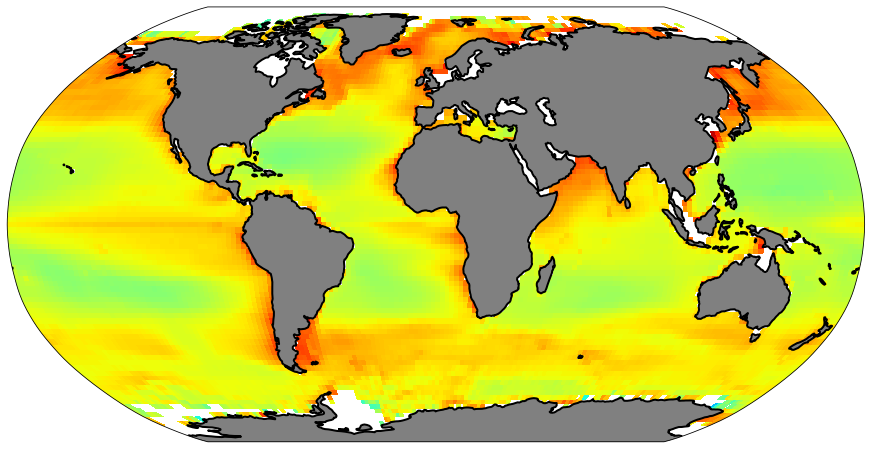

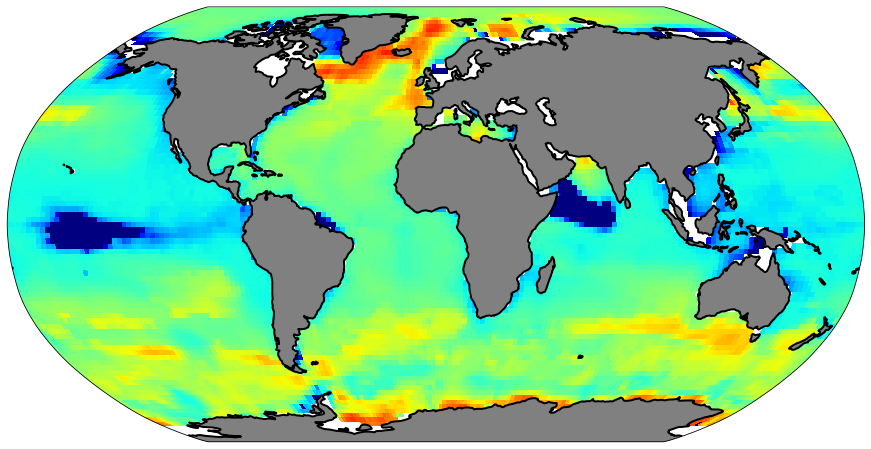

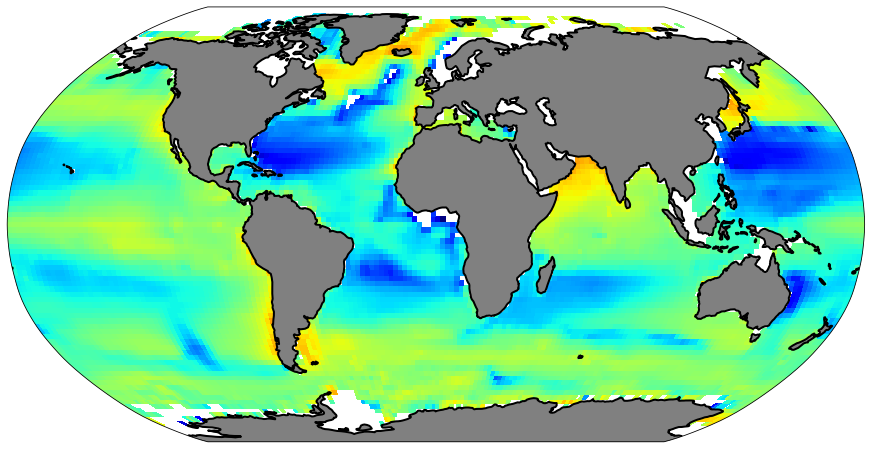

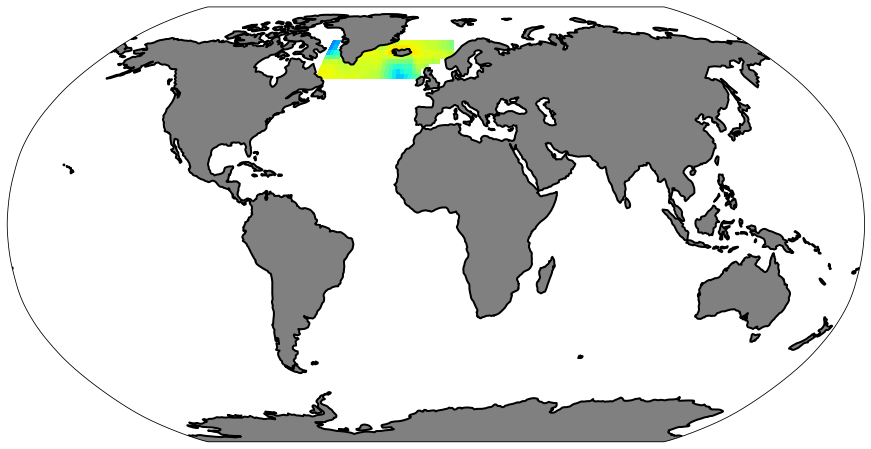

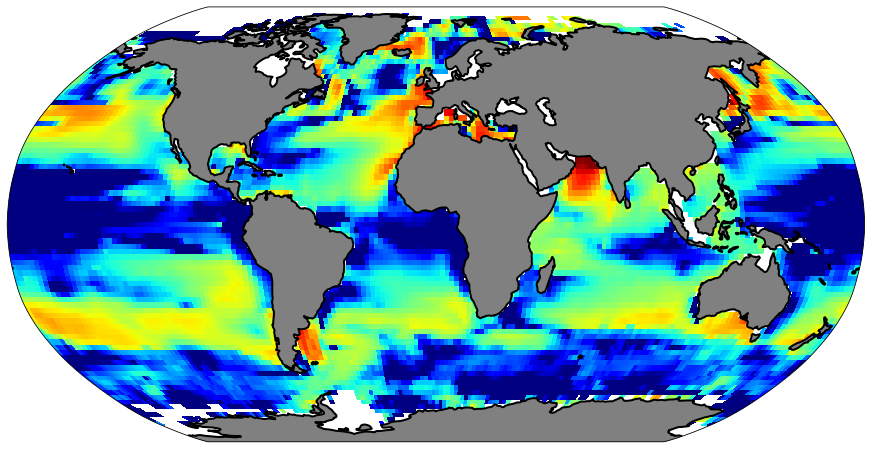

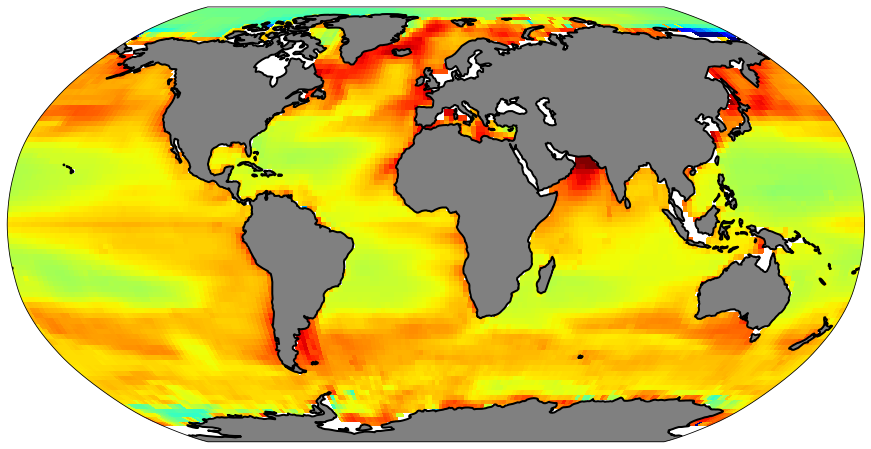

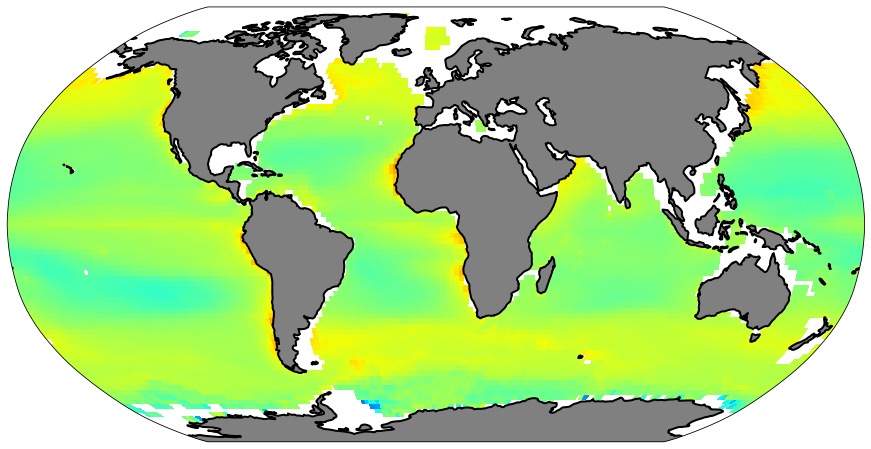

In [83]:
# SAVE DATA FOR FIGS

# ATTENTION FOR NEGATIVE VALUES OR VERY SMALL VALUES, WE PUT THEM AT THE SCALE MINIMUM
FseqDOC_H_100m = np.where(FseqDOC_H_100m<1e-3, 1e-3, FseqDOC_H_100m) 
FseqTop_H_100m = np.where(FseqTop_H_100m<1e-3, 1e-3, FseqTop_H_100m)

cmap = 'jet'
#cmap = 'viridis'

plot_map((20,8), lonT, latT, FseqPOC_H_100m, 1e-3, 1e2, '', '', True, 'FseqPOC.jpg', mask, cmap = cmap, folder = './FigS2/Martin/', plt_show = True, use_log_scale = True, use_colorbar = False)
plot_map((20,8), lonT, latT, FseqDOC_H_100m, 1e-3, 1e2, '', '', True, 'FseqDOC.jpg', mask, cmap = cmap, folder = './FigS2/Martin/', plt_show = True, use_log_scale = True, use_colorbar = False)
plot_map((20,8), lonT, latT, FseqMigrD_H_100m, 1e-3, 1e2, '', '', True, 'FseqMigrD.jpg', mask, cmap = cmap, folder = './FigS2/Martin/', plt_show = True, use_log_scale = True, use_colorbar = False)
plot_map((20,8), lonT, latT, FseqMigrS_H_100m, 1e-3, 1e2, '', '', True, 'FseqMigrS.jpg', mask, cmap = cmap, folder = './FigS2/Martin/', plt_show = True, use_log_scale = True, use_colorbar = False)
plot_map((20,8), lonT, latT, FseqTop_H_100m, 1e-3, 1e2, '', '', True, 'FseqTop.jpg', mask, cmap = cmap, folder = './FigS2/Martin/', plt_show = True, use_log_scale = True, use_colorbar = False)
plot_map((20,8), lonT, latT, FseqBCPs_H_100m, 1e-3, 1e2, '', '', True, 'FseqBCPs.jpg', mask, cmap = cmap, folder = './FigS2/Martin/', plt_show = True, use_log_scale = True, use_colorbar = False)
plot_map((20,8), lonT, latT, FseqPOC2000m_martin, 1e-3, 1e2, '', '', True, 'FseqPOC2000m.jpg', mask, cmap = cmap, folder = './FigS2/Martin/', plt_show = True, use_log_scale = True, use_colorbar = False)

In [84]:
# # SAVE DATA FOR FIG 4
# plot_map((20,8), lonT, latT, FseqPOC_H_100m, 1e-3, 1e2, 'F$_{seq}$ = '+str(0.74)+' Pg C y$^{-1}$   F$^{*}_{seq}$ ='+str(0.18), '', True, 'FseqPOC.jpg', mask, cmap = 'jet', folder = './Fig4/Export_H_100m_martin/', plt_show = False, use_log_scale = True, use_colorbar = False)
# plot_map((20,8), lonT, latT, FseqBCPs_H_100m, 1e-3, 1e2, 'F$_{seq}$ = '+str(0)+' Pg C y$^{-1}$   F$^{*}_{seq}$ ='+str(0.18), '', True, 'FseqBCPs_H_100m.jpg', mask, cmap = 'jet', folder = './Fig4/Export_H_100m_martin/', plt_show = False, use_log_scale = True, use_colorbar = False)
# plot_map((20,8), lonT, latT, FseqPOC2000m_martin, 1e-3, 1e2, 'F$_{seq}$ = '+str(0.74)+' Pg C y$^{-1}$   F$^{*}_{seq}$ ='+str(0.18), '', True, 'FseqPOC2000m_martin.jpg', mask, cmap = 'jet', folder = './Fig4/Export_H_100m_martin/', plt_show = False, use_log_scale = True, use_colorbar = False)

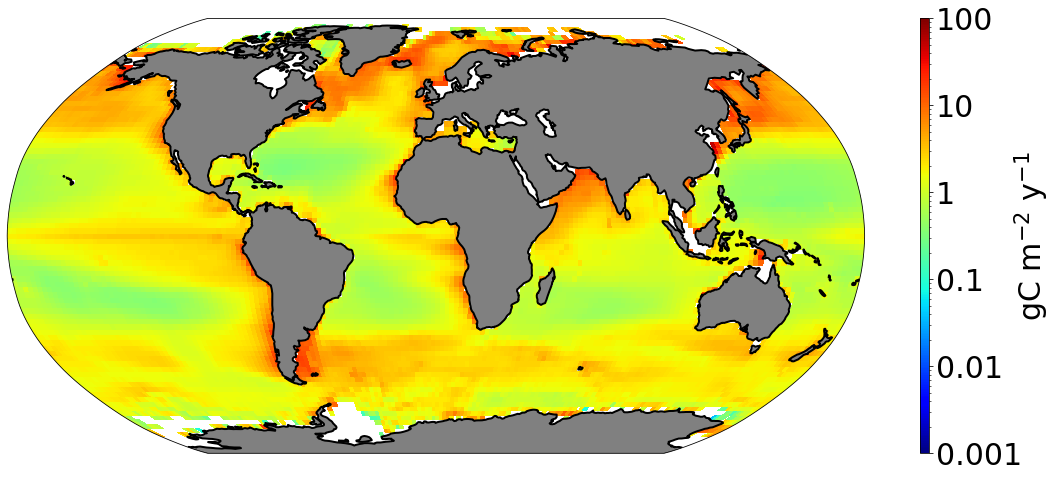

In [85]:
fig, ax = plt.subplots(1,1,figsize=(20,8),subplot_kw={'projection': ccrs.Robinson()})
ax.add_feature(land_110m)
ax.coastlines(resolution='110m', color='black', linestyle='-', alpha=1, linewidth = 2)
p = ax.pcolormesh(lonT, latT, FseqPOC_H_100m*mask, shading = 'auto', vmin = 1e-3, vmax = 1e2, transform=ccrs.PlateCarree(), cmap = 'jet', norm=colors.LogNorm())
cbar = plt.colorbar(p, orientation='vertical', aspect = 50, pad = 0.05)
cbar.set_label('gC m$^{-2}$ y$^{-1}$', fontsize = 30, labelpad = -10)
cbar.set_ticks([1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2])
cbar.set_ticklabels([0.001, 0.01, 0.1, 1, 10, 100])
cbar.ax.tick_params(labelsize=30)
plt.savefig('./Fig4/log_colorbar.jpg')

# Geographically variable b (Henson)

In [86]:
# POC below Zexp (Top)
FreminPOC_H_water_100m, FseqPOC_H_water_100m = compute_sequestration_in_water(zmax, depthT, b_henson, f100, FexpH, ZexpH)
FseqPOC_H_sed_100m = compute_sequestration_in_sediment(zmax, b_henson, FexpH, ZexpH)
FseqPOC_H_100m = compute_Fseq_pixel_below_Top(FseqPOC_H_sed_100m, FseqPOC_H_water_100m)

# DOC below Top
FseqDOC_H_100m = FseqDOC_ST_100m * ratio_export_global # if Zexp = 100m

# Migration Daily
FreminMigrD_H_100m, FseqMigrD_H_100m = compute_FmigrD(FexpH)

# Migration Seasonally
FreminMigrS_H_100m = np.zeros((12,91,180))
FseqMigrS_H_100m = np.zeros((12,91,180))
for i in range(12):
    FreminMigrS_H_100m[i,:,:], FseqMigrS_H_100m[i,:,:] = compute_Fseq_migr_seasonal(b_henson, FexpH, ZexpH, POCflux[i,:,:,:], False)
# average
FreminMigrS_H_100m = np.nanmean(FreminMigrS_H_100m, axis = 0)
FseqMigrS_H_100m = np.nanmean(FseqMigrS_H_100m, axis = 0)

# Top layer
FreminTop_H_100m, FseqTop_H_100m = compute_FseqTop(ppH, FexpDOC_H_100m, FexpH, FreminMigrD_H_100m, FreminMigrS_H_100m, f100_Top)

# Fseq(2000m)
FseqPOC2000m_henson = np.zeros((12,91,180))
for i in range(12):
    FseqPOC2000m_henson[i,:,:] = compute_FseqPOC_2000m(b_henson, FexpH, ZexpH, POCflux[i,:,:,:])
FseqPOC2000m_henson = np.nanmean(FseqPOC2000m_henson, axis = 0)

# Henson - b Martin
print('CHECK THAT IT WAS COMPUTED FOR B HENSON')
printResult(FseqPOC_H_100m, FseqDOC_H_100m, FseqMigrD_H_100m, FseqMigrS_H_100m, FseqTop_H_100m, pixelArea, mask)
# with ratio reference
printResult_ratio_reference(FseqPOC_H_100m, FseqDOC_H_100m, FseqMigrD_H_100m, FseqMigrS_H_100m, FseqTop_H_100m, pixelArea, mask, FexpH)
print('')
FseqBCPs_H_100m = printResult_mean_median(FseqPOC_H_100m, FseqDOC_H_100m, FseqMigrD_H_100m, FseqMigrS_H_100m, FseqTop_H_100m, pixelArea, mask)
print('\nSequestration flux at 2000 m:', np.round(compute_flux_total(FseqPOC2000m_henson*mask, pixelArea), 2))
ref = compute_flux_total(FexpH, pixelArea)
print('F*seq(2000):', np.round(compute_flux_total(FseqPOC2000m_henson*mask, pixelArea)/ref, 2))

min_valMigrS, max_valMigrS, median_valMigrS = compute_min_max_median_FreminMigrS(FreminMigrS_H_100m)
print('\nValues min/max/median for FseqMigrS:')
print('Min: ', np.round(min_valMigrS, 2))
print('Max: ', np.round(max_valMigrS, 2))
print('Median: ', np.round(median_valMigrS, 2))

<ipython-input-86-2ec449c140a0>:18: RuntimeWarning: Mean of empty slice
  FreminMigrS_H_100m = np.nanmean(FreminMigrS_H_100m, axis = 0)
<ipython-input-86-2ec449c140a0>:19: RuntimeWarning: Mean of empty slice
  FseqMigrS_H_100m = np.nanmean(FseqMigrS_H_100m, axis = 0)


CHECK THAT IT WAS COMPUTED FOR B HENSON
Global Fseq(POC): 1.04  GtC/year
Global Fseq(DOC): 0.17  GtC/year
Global Fseq(Migr Diel): 0.11  GtC/year
Global Fseq(Migr Season): 0.004  GtC/year
Global Fseq(Top): 0.29  GtC/year
Global BCPs: 1.62 GtC/year
Global Fexp: 4.05 GtC/year
Global F*seq(POC): 0.26
Global F*seqBCPs: 0.4

MEDIAN VALUES
Median Fseq(POC): 2.26  gC/m2/year
Median Fseq(DOC): 0.24  gC/m2/year
Median Fseq(Migr Diel): 0.21  gC/m2/year
Median Fseq(Migr Season): 0.94  gC/m2/year
Median Fseq(Top): 0.04  gC/m2/year
Median BCPs: 2.98 gC/m2/year

MEAN VALUES
Mean Fseq(POC): 3.06  gC/m2/year
Mean Fseq(DOC): 0.67  gC/m2/year
Mean Fseq(Migr Diel): 0.37  gC/m2/year
Mean Fseq(Migr Season): 0.88  gC/m2/year
Mean Fseq(Top): 0.83  gC/m2/year
Mean BCPs: 4.48 gC/m2/year

Sequestration flux at 2000 m: 0.42
F*seq(2000): 0.1

Values min/max/median for FseqMigrS:
Min:  0.49
Max:  3.48
Median:  2.0


<ipython-input-86-2ec449c140a0>:28: RuntimeWarning: Mean of empty slice
  FseqPOC2000m_henson = np.nanmean(FseqPOC2000m_henson, axis = 0)


In [87]:
compute_pixel_area_version(FseqPOC_H_100m, FseqDOC_H_100m, FseqMigrD_H_100m, FseqMigrS_H_100m, FseqTop_H_100m, FseqBCPs_H_100m, FseqPOC2000m_henson, pixelArea, mask)

FseqPOC pixel + area: (9235, 343.60638433698176)
FseqDOC pixel + area: (10276, 351.7488109020153)
FseqMigrD pixel + area: (9072, 340.1940115804165)
FseqMigrS pixel + area: (205, 4.696420385705691)
FseqTop pixel + area: (9238, 343.6552228630314)
FseqBCPs pixel + area: (10333, 353.0895822119404)
Fseq2000m pixel + area: (7952, 308.33030463063744)


In [88]:
# SAVE DATA FOR FIGS

# ATTENTION FOR NEGATIVE VALUES OR VERY SMALL VALUES, WE PUT THEM AT THE SCALE MINIMUM
FseqDOC_H_100m = np.where(FseqDOC_H_100m<1e-3, 1e-3, FseqDOC_H_100m) 
FseqTop_H_100m = np.where(FseqTop_H_100m<1e-3, 1e-3, FseqTop_H_100m)

plot_map((20,8), lonT, latT, FseqPOC_H_100m, 1e-3, 1e2, '', '', True, 'FseqPOC.jpg', mask, cmap = 'jet', folder = './FigS2/Henson/', plt_show = False, use_log_scale = True, use_colorbar = False)
plot_map((20,8), lonT, latT, FseqDOC_H_100m, 1e-3, 1e2, '', '', True, 'FseqDOC.jpg', mask, cmap = 'jet', folder = './FigS2/Henson/', plt_show = False, use_log_scale = True, use_colorbar = False)
plot_map((20,8), lonT, latT, FseqMigrD_H_100m, 1e-3, 1e2, '', '', True, 'FseqMigrD.jpg', mask, cmap = 'jet', folder = './FigS2/Henson/', plt_show = False, use_log_scale = True, use_colorbar = False)
plot_map((20,8), lonT, latT, FseqMigrS_H_100m, 1e-3, 1e2, '', '', True, 'FseqMigrS.jpg', mask, cmap = 'jet', folder = './FigS2/Henson/', plt_show = False, use_log_scale = True, use_colorbar = False)
plot_map((20,8), lonT, latT, FseqTop_H_100m, 1e-3, 1e2, '', '', True, 'FseqTop.jpg', mask, cmap = 'jet', folder = './FigS2/Henson/', plt_show = False, use_log_scale = True, use_colorbar = False)
plot_map((20,8), lonT, latT, FseqBCPs_H_100m, 1e-3, 1e2, '', '', True, 'FseqBCPs.jpg', mask, cmap = 'jet', folder = './FigS2/Henson/', plt_show = False, use_log_scale = True, use_colorbar = False)
plot_map((20,8), lonT, latT, FseqPOC2000m_henson, 1e-3, 1e2, '', '', True, 'FseqPOC2000m.jpg', mask, cmap = 'jet', folder = './FigS2/Henson/', plt_show = False, use_log_scale = True, use_colorbar = False)

In [89]:
# SAVE DATA FOR FIG 4
plot_map((20,8), lonT, latT, FseqPOC_H_100m, 1e-3, 1e2, 'F$_{seq}$ = '+str(np.round(compute_flux_total(FseqPOC_H_100m*mask, pixelArea), 2))+' Pg C y$^{-1}$   F$^{*}_{seq}$ = '+str(np.round(compute_flux_total(FseqPOC_H_100m*mask, pixelArea)/ref, 2)), '', True, 'FseqPOC.jpg', mask, cmap = 'jet', folder = './Fig4/Export_H_100m_henson/', plt_show = False, use_log_scale = True, use_colorbar = False)
plot_map((20,8), lonT, latT, FseqBCPs_H_100m, 1e-3, 1e2, 'F$_{seq}$ = '+str(np.round(compute_flux_total(FseqBCPs_H_100m*mask, pixelArea), 2))+' Pg C y$^{-1}$   F$^{*}_{seq}$ = '+str(np.round(compute_flux_total(FseqBCPs_H_100m*mask, pixelArea)/ref, 2)), '', True, 'FseqBCPs.jpg', mask, cmap = 'jet', folder = './Fig4/Export_H_100m_henson/', plt_show = False, use_log_scale = True, use_colorbar = False)
plot_map((20,8), lonT, latT, FseqPOC2000m_henson, 1e-3, 1e2, 'F$_{seq}$ = '+str(np.round(compute_flux_total(FseqPOC2000m_henson*mask, pixelArea), 2))+' Pg C y$^{-1}$   F$^{*}_{seq}$ = '+str(np.round(compute_flux_total(FseqPOC2000m_henson*mask, pixelArea)/ref, 2)), '', True, 'FseqPOC2000m.jpg', mask, cmap = 'jet', folder = './Fig4/Export_H_100m_henson/', plt_show = False, use_log_scale = True, use_colorbar = False)

# Regionally variable b (Guidi)

In [90]:
# POC below Zexp (Top)
FreminPOC_H_water_100m, FseqPOC_H_water_100m = compute_sequestration_in_water(zmax, depthT, b_guidi, f100, FexpH, ZexpH)
FseqPOC_H_sed_100m = compute_sequestration_in_sediment(zmax, b_guidi, FexpH, ZexpH)
FseqPOC_H_100m = compute_Fseq_pixel_below_Top(FseqPOC_H_sed_100m, FseqPOC_H_water_100m)

# DOC below Top
FseqDOC_H_100m = FseqDOC_ST_100m * ratio_export_global # if Zexp = 100m

# Migration Daily
FreminMigrD_H_100m, FseqMigrD_H_100m = compute_FmigrD(FexpH)

# Migration Seasonally
FreminMigrS_H_100m = np.zeros((12,91,180))
FseqMigrS_H_100m = np.zeros((12,91,180))
for i in range(12):
    FreminMigrS_H_100m[i,:,:], FseqMigrS_H_100m[i,:,:] = compute_Fseq_migr_seasonal(b_guidi, FexpH, ZexpH, POCflux[i,:,:,:], False)
# average
FreminMigrS_H_100m = np.nanmean(FreminMigrS_H_100m, axis = 0)
FseqMigrS_H_100m = np.nanmean(FseqMigrS_H_100m, axis = 0)

# Top layer
FreminTop_H_100m, FseqTop_H_100m = compute_FseqTop(ppH, FexpDOC_H_100m, FexpH, FreminMigrD_H_100m, FreminMigrS_H_100m, f100_Top)

# Fseq(2000m)
FseqPOC2000m_guidi = np.zeros((12,91,180))
for i in range(12):
    FseqPOC2000m_guidi[i,:,:] = compute_FseqPOC_2000m(b_guidi, FexpH, ZexpH, POCflux[i,:,:,:])
FseqPOC2000m_guidi = np.nanmean(FseqPOC2000m_guidi, axis = 0)

# Henson - b Martin
print('CHECK THAT IT WAS COMPUTED FOR B GUIDI')
printResult(FseqPOC_H_100m, FseqDOC_H_100m, FseqMigrD_H_100m, FseqMigrS_H_100m, FseqTop_H_100m, pixelArea, mask)
# with ratio reference
printResult_ratio_reference(FseqPOC_H_100m, FseqDOC_H_100m, FseqMigrD_H_100m, FseqMigrS_H_100m, FseqTop_H_100m, pixelArea, mask, FexpH)
print('')
FseqBCPs_H_100m = printResult_mean_median(FseqPOC_H_100m, FseqDOC_H_100m, FseqMigrD_H_100m, FseqMigrS_H_100m, FseqTop_H_100m, pixelArea, mask)
print('\nSequestration flux at 2000 m:', np.round(compute_flux_total(FseqPOC2000m_guidi*mask, pixelArea), 2))
ref = compute_flux_total(FexpH, pixelArea)
print('F*seq(2000):', np.round(compute_flux_total(FseqPOC2000m_guidi*mask, pixelArea)/ref, 2))

min_valMigrS, max_valMigrS, median_valMigrS = compute_min_max_median_FreminMigrS(FreminMigrS_H_100m)
print('\nValues min/max/median for FseqMigrS:')
print('Min: ', np.round(min_valMigrS, 2))
print('Max: ', np.round(max_valMigrS, 2))
print('Median: ', np.round(median_valMigrS, 2))

<ipython-input-90-24c6de8c8751>:18: RuntimeWarning: Mean of empty slice
  FreminMigrS_H_100m = np.nanmean(FreminMigrS_H_100m, axis = 0)
<ipython-input-90-24c6de8c8751>:19: RuntimeWarning: Mean of empty slice
  FseqMigrS_H_100m = np.nanmean(FseqMigrS_H_100m, axis = 0)


CHECK THAT IT WAS COMPUTED FOR B GUIDI
Global Fseq(POC): 0.82  GtC/year
Global Fseq(DOC): 0.17  GtC/year
Global Fseq(Migr Diel): 0.11  GtC/year
Global Fseq(Migr Season): 0.001  GtC/year
Global Fseq(Top): 0.29  GtC/year
Global BCPs: 1.4 GtC/year
Global Fexp: 4.05 GtC/year
Global F*seq(POC): 0.2
Global F*seqBCPs: 0.35

MEDIAN VALUES
Median Fseq(POC): 1.69  gC/m2/year
Median Fseq(DOC): 0.24  gC/m2/year
Median Fseq(Migr Diel): 0.21  gC/m2/year
Median Fseq(Migr Season): 0.21  gC/m2/year
Median Fseq(Top): 0.04  gC/m2/year
Median BCPs: 2.34 gC/m2/year

MEAN VALUES
Mean Fseq(POC): 2.43  gC/m2/year
Mean Fseq(DOC): 0.67  gC/m2/year
Mean Fseq(Migr Diel): 0.37  gC/m2/year
Mean Fseq(Migr Season): 0.24  gC/m2/year
Mean Fseq(Top): 0.83  gC/m2/year
Mean BCPs: 3.92 gC/m2/year

Sequestration flux at 2000 m: 0.26
F*seq(2000): 0.06

Values min/max/median for FseqMigrS:
Min:  0.18
Max:  4.1
Median:  0.46


<ipython-input-90-24c6de8c8751>:28: RuntimeWarning: Mean of empty slice
  FseqPOC2000m_guidi = np.nanmean(FseqPOC2000m_guidi, axis = 0)


In [91]:
compute_pixel_area_version(FseqPOC_H_100m, FseqDOC_H_100m, FseqMigrD_H_100m, FseqMigrS_H_100m, FseqTop_H_100m, FseqBCPs_H_100m, FseqPOC2000m_guidi, pixelArea, mask)

FseqPOC pixel + area: (9235, 343.60638433698176)
FseqDOC pixel + area: (10276, 351.7488109020153)
FseqMigrD pixel + area: (9072, 340.1940115804165)
FseqMigrS pixel + area: (205, 4.696420385705691)
FseqTop pixel + area: (9238, 343.6552228630314)
FseqBCPs pixel + area: (10333, 353.0895822119404)
Fseq2000m pixel + area: (7952, 308.33030463063744)


In [92]:
# SAVE DATA FOR FIGS

# ATTENTION FOR NEGATIVE VALUES OR VERY SMALL VALUES, WE PUT THEM AT THE SCALE MINIMUM
FseqDOC_H_100m = np.where(FseqDOC_H_100m<1e-3, 1e-3, FseqDOC_H_100m) 
FseqTop_H_100m = np.where(FseqTop_H_100m<1e-3, 1e-3, FseqTop_H_100m)

plot_map((20,8), lonT, latT, FseqPOC_H_100m, 1e-3, 1e2, '', '', True, 'FseqPOC.jpg', mask, cmap = 'jet', folder = './FigS2/Guidi/', plt_show = False, use_log_scale = True, use_colorbar = False)
plot_map((20,8), lonT, latT, FseqDOC_H_100m, 1e-3, 1e2, '', '', True, 'FseqDOC.jpg', mask, cmap = 'jet', folder = './FigS2/Guidi/', plt_show = False, use_log_scale = True, use_colorbar = False)
plot_map((20,8), lonT, latT, FseqMigrD_H_100m, 1e-3, 1e2, '', '', True, 'FseqMigrD.jpg', mask, cmap = 'jet', folder = './FigS2/Guidi/', plt_show = False, use_log_scale = True, use_colorbar = False)
plot_map((20,8), lonT, latT, FseqMigrS_H_100m, 1e-3, 1e2, '', '', True, 'FseqMigrS.jpg', mask, cmap = 'jet', folder = './FigS2/Guidi/', plt_show = False, use_log_scale = True, use_colorbar = False)
plot_map((20,8), lonT, latT, FseqTop_H_100m, 1e-3, 1e2, '', '', True, 'FseqTop.jpg', mask, cmap = 'jet', folder = './FigS2/Guidi/', plt_show = False, use_log_scale = True, use_colorbar = False)
plot_map((20,8), lonT, latT, FseqBCPs_H_100m, 1e-3, 1e2, '', '', True, 'FseqBCPs.jpg', mask, cmap = 'jet', folder = './FigS2/Guidi/', plt_show = False, use_log_scale = True, use_colorbar = False)
plot_map((20,8), lonT, latT, FseqPOC2000m_guidi, 1e-3, 1e2, '', '', True, 'FseqPOC2000m.jpg', mask, cmap = 'jet', folder = './FigS2/Guidi/', plt_show = False, use_log_scale = True, use_colorbar = False)

In [93]:
# SAVE DATA FOR FIG 4
plot_map((20,8), lonT, latT, FseqPOC_H_100m, 1e-3, 1e2, 'F$_{seq}$ = '+str(np.round(compute_flux_total(FseqPOC_H_100m*mask, pixelArea), 2))+' Pg C y$^{-1}$   F$^{*}_{seq}$ = '+str(np.round(compute_flux_total(FseqPOC_H_100m*mask, pixelArea)/ref, 2)), '', True, 'FseqPOC.jpg', mask, cmap = 'jet', folder = './Fig4/Export_H_100m_guidi/', plt_show = False, use_log_scale = True, use_colorbar = False)
plot_map((20,8), lonT, latT, FseqBCPs_H_100m, 1e-3, 1e2, 'F$_{seq}$ = '+str(np.round(compute_flux_total(FseqBCPs_H_100m*mask, pixelArea), 2))+' Pg C y$^{-1}$   F$^{*}_{seq}$ = '+str(np.round(compute_flux_total(FseqBCPs_H_100m*mask, pixelArea)/ref, 2)), '', True, 'FseqBCPs.jpg', mask, cmap = 'jet', folder = './Fig4/Export_H_100m_guidi/', plt_show = False, use_log_scale = True, use_colorbar = False)
plot_map((20,8), lonT, latT, FseqPOC2000m_guidi, 1e-3, 1e2, 'F$_{seq}$ = '+str(np.round(compute_flux_total(FseqPOC2000m_guidi*mask, pixelArea), 2))+' Pg C y$^{-1}$   F$^{*}_{seq}$ = '+str(np.round(compute_flux_total(FseqPOC2000m_guidi*mask, pixelArea)/ref, 2)), '', True, 'FseqPOC2000m.jpg', mask, cmap = 'jet', folder = './Fig4/Export_H_100m_guidi/', plt_show = False, use_log_scale = True, use_colorbar = False)

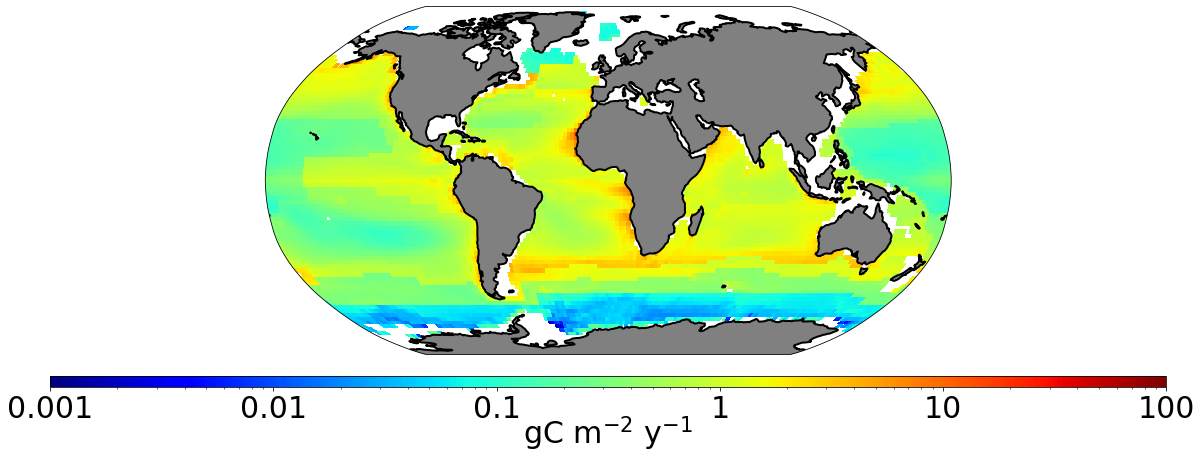

In [94]:
plot_map((20,8), lonT, latT, FseqPOC2000m_guidi, 1e-3, 1e2, '', 'gC m$^{-2}$ y$^{-1}$', True, 'log_colorbar.jpg', mask, cmap = 'jet', folder = './FigS2/Guidi/', plt_show = True, use_log_scale = True, use_colorbar = True)

# Figure S4 + shiny App

In [95]:
POCreminSlow = np.zeros(POCslow.shape)
for i in range(12):
    POCreminSlow[i,:,:,:] = POCslow[i,:,:,:] * kslow[i]
    
POCreminFast = np.zeros(POCfast.shape)
for i in range(12):
    POCreminFast[i,:,:,:] = POCfast[i,:,:,:] * kfast[i]
    
POCreminTotal = add_matrix(POCreminSlow, POCreminFast)

FreminPOC = np.zeros(POCreminTotal.shape)
for i in range(12):
    FreminPOC[i,:,:,:] = POCreminTotal[i,:,:,:] * deltaZ_matrix
    
FseqPOC = np.zeros(POCreminTotal.shape)
for i in range(12):
    FseqPOC[i,:,:,:] = FreminPOC[i,:,:,:] * f100_ST

    
FseqPOC_ST2 = np.nansum(FseqPOC[:,:,:,3:], axis = 3)
FseqPOC_ST2 = np.where(FseqPOC_ST2 == 0.0, np.nan, FseqPOC_ST2) # replace 0 with NaN (sum of NaN in Python gives 0)   
FseqPOC_pixel_averaged = np.nanmean(FseqPOC_ST2, axis = 0)  

<ipython-input-95-d96f43418624>:22: RuntimeWarning: Mean of empty slice
  FseqPOC_pixel_averaged = np.nanmean(FseqPOC_ST2, axis = 0)


In [96]:
scipy.io.savemat('figureS4_data_100322.mat', {'f100': f100, 
                                            #'FseqPOC_H_water_100m':FseqPOC_H_water_100m,
                                            #'FseqPOC_H_100m':FseqPOC_H_100m,
                                            'lon': lonT, 
                                            'lat': latT, 
                                            #'depth_H': depthT, 
                                            'f100_ST': f100_ST, 
                                            'depthST': depthST, 
                                            #'POCflux':POCflux,
                                            #'FseqPOC_ST_100m_total':FseqPOC_ST_100m,
                                            'POCslow':POCslow,
                                            'POCfast':POCfast,
                                            'POCtotal':POCslow+POCfast,
                                            'POCreminSlow':POCreminSlow,
                                            'POCreminFast':POCreminFast,
                                            'POCreminTotal':POCreminTotal,
                                            'DeltaZ':deltaZ_matrix,
                                            'FreminPOC': FreminPOC,
                                            'FseqPOC':FseqPOC,
                                            'FseqPOC_pixel':FseqPOC_ST2,
                                            'FseqPOC_pixel_averaged':FseqPOC_pixel_averaged#,
                                            #'POCflux':POCflux
                                            })